# Rossmann Sales Prediction

## About Sales Prediction

In the world of retail, accurate sales prediction is key for companies like Rossmann. Sales prediction is the practice of leveraging historical data and data-driven methodologies to anticipate future sales trends, enabling businesses to make informed decisions on inventory management, marketing strategies, and resource allocation. 

## About Rossmann

Rossmann, a prominent European drug store and retail chain, plays a vital role in the daily lives of countless customers across multiple countries. With a vast array of products, from cosmetics and personal care items to household essentials, Rossmann has become a go-to destination for shoppers seeking quality goods at competitive prices. 

In this data science project, I delve into the challenge of forecasting Rossmann store revenues, a task with significant implications for the company's operations and decision-making. By leveraging data-driven insights and predictive models, I aim to uncover patterns and trends that can help Rossmann optimize its business strategies and improve its performance.

## Business Problem

**Business Challenge: Developing a Sales Prediction Model**

A sales prediction model for the following six weeks will be developed in order to predict how much money each store of the company will have available to spend on their renovation.

## 0. Imports

### 0.1. Libraries

In [290]:
### Data Manipulation
import pandas                   as pd
import numpy                    as np
import math

### Data Visualization
import seaborn                  as sns
import matplotlib               as mpl
import matplotlib.pyplot        as plt
import matplotlib.dates         as mdates

### Machine Learning
from sklearn.metrics            import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.ensemble           import RandomForestRegressor
from sklearn.model_selection    import train_test_split

import xgboost                  as xgb
import lightgbm                 as lgb

### Other Libraries
import inflection
import datetime 
import warnings
import locale
import random
import lxml

### 0.2. Settings

In [138]:
### Ignoring warnings
warnings.filterwarnings('ignore')

### Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

### Visualization Settings
mpl.style.use('ggplot')

mpl.rcParams['figure.titlesize']    = 24
mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

sns.set_palette('YlOrBr_r')

### 0.3. Functions

In [292]:
### Data manipulation functions

def df_shape(df):
    """
    Summary:
        The function prints the number of rows and columns of a given DataFrame.

    Args:
        df: the DataFrame we want to know more about.
    
    Returns:
        text: text indicating the number of rows and columns of the DataFrame.
    """

    print('Number of rows: {:,}'.format(df.shape[0]))
    print('Number of columns: {:,}'.format(df.shape[1]))

    return None

### Visualization functions

def set_image(title, xlabel, ylabel, rotation=0):
    """
    Summary: This function sets the image configuration.

    Args:
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
        rotation: the rotation of the labels. default as 0.

    Returns: None
    """

    plt.title(title)
    plt.xlabel(xlabel, color='black')
    plt.ylabel(ylabel, color='black')
    plt.xticks(rotation=rotation)
    plt.tick_params(left=False, bottom=False);

    return None

### Model functions

def ml_error(model_name, y, y_hat):
    """
    Summary:
        The function calculates error metrics for the ML model such as MAE, MAPE, RMSE and R2.

    Args:
        model_name: name of the model.
        y: true values for the response variable.
        y_hat: predicted values for the response variable.
    
    Returns:
        DataFrame: A dataframe with Model name, MAE, MAPE, RMSE and R2.
    """

    mae =   mean_absolute_error(y, y_hat)
    mape =  mean_absolute_percentage_error(y, y_hat)
    rmse =  np.sqrt(mean_squared_error(y, y_hat))
    r2 =    r2_score(y, y_hat)
    
    return pd.DataFrame({'Model':   model_name,
                         'MAE':     np.round(mae,2),
                         'MAPE':    np.round(mape,4),
                         'RMSE':    np.round(rmse,2),
                         'R2':      np.round(r2,4)}, 
                         index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    """
    Summary:
        Splits the data into train and validation, fits the given model for each kfold, 
        makes predictions and returns a DataFrame with metrics.

    Args:
        x_training:     the dataset used for training.
        kfold:          number of folds in cross validation. 
        model_name:     name of the model used.
        model:          the initialized model.
        
    Returns:
        DataFrame: Contains cross-validation Model Name, MAE, MAPE, RMSE and R2.
    
    """
    mae_list    = []
    mape_list   = []
    rmse_list   = []
    r2_list     = []

    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('\n KFold Iteration {}.'.format(k))
        # Start and end date for validation
        validation_start_date   = x_training['date'].max() - datetime.timedelta(days=k*6*7) 
        validation_end_date     = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtering dataset
        training    = x_training[x_training['date'] < validation_start_date] 
        validation  = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)] 

        # Training dataset
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']

        # Validation dataset
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        y_hat = m.predict(xvalidation)

        # Metrics
        result = ml_error(model_name, yvalidation, y_hat)
        
        # Store the performance of each kfold iteration        
        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])
        r2_list.append(result['R2'])
        
    return pd.DataFrame({'Model CV':   model_name,
                         'MAE CV':     np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV':    np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),4).astype(str),
                         'RMSE CV':    np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str),
                         'R2 CV':      np.round(np.mean(r2_list),4).astype(str) + ' +/- ' + np.round(np.std(r2_list),4).astype(str)}, 
                         index=[0]) 
 
def random_search_lgbm(search_space, x_train, y_train, trials):
    """
    Summary:
        Random search hyperparameter optimization on LGBM Regressor model.

    Args:
        search_space:   dictionary of parameters.
        x_train:        x training data.
        y_train:        y training data.
        trials:         number of parameters combinations.
        
    Returns:
        lgbm_results: dataframe with all estimated LGBM models and their respective metrics.
    
    """ 
    lgbm_results = pd.DataFrame()   

    for i in range(trials):       
        hp = {k: random.sample(v, 1)[0] for k, v in search_space.items()}  
        
        print(hp)

        # Model
        model = lgb.LGBMRegressor(  objective = 'regression', 
                                    random_state = 42, 
                                    subsample = 0.7, 
                                    colsample_bytree = 0.9, 
                                    min_child_samples = 100, 
                                    n_estimators = hp['n_estimators'],
                                    learning_rate = hp['learning_rate'],
                                    max_depth = hp['max_depth'],
                                    num_leaves = hp['num_leaves']).fit(x_train, y_train)
        
        # Prediction
        yhat_lgbm = model.predict(x_test)

        # Performance
        results = ml_error('LGBM Regressor', y_test, yhat_lgbm)
        
        lgbm_results = pd.concat([lgbm_results, results])

    return lgbm_results 

### 0.4. Dataset

In [141]:
# Importing data
df_store = pd.read_csv('../data/raw/store.csv', nrows=236380)
df_sales = pd.read_csv('../data/raw/train.csv', nrows=236380)

# Merging dataframes
df_merge = pd.merge(df_sales, df_store, how='left', on='Store')

# Export merge dataframe
# df_merge.to_csv('../data/interim/df_merge.csv')

# Working with df as main dataframe
df = df_merge.copy()

## 1. Data Description

In [142]:
df['Store'].value_counts()

1       212
742     212
748     212
747     212
746     212
       ... 
378     212
379     212
380     212
381     212
1115    212
Name: Store, Length: 1115, dtype: int64

In [143]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


### 1.1. Data dimensions

In [144]:
df_shape(df)

Number of rows: 236,380
Number of columns: 18


### 1.2. Columns

In [145]:
df.columns.to_list()

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

### 1.3. Data types

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236380 entries, 0 to 236379
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      236380 non-null  int64  
 1   DayOfWeek                  236380 non-null  int64  
 2   Date                       236380 non-null  object 
 3   Sales                      236380 non-null  int64  
 4   Customers                  236380 non-null  int64  
 5   Open                       236380 non-null  int64  
 6   Promo                      236380 non-null  int64  
 7   StateHoliday               236380 non-null  object 
 8   SchoolHoliday              236380 non-null  int64  
 9   StoreType                  236380 non-null  object 
 10  Assortment                 236380 non-null  object 
 11  CompetitionDistance        235744 non-null  float64
 12  CompetitionOpenSinceMonth  161332 non-null  float64
 13  CompetitionOpenSinceYear   16

### 1.4. Describing data

In [147]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,236380.00,558.00,321.87,1.00,279.00,558.00,837.00,1115.00
DayOfWeek,236380.00,4.00,1.99,1.00,2.00,4.00,6.00,7.00
Sales,236380.00,5878.25,3840.20,0.00,3892.00,5916.00,7997.00,41551.00
Customers,236380.00,624.20,452.87,0.00,410.00,606.00,823.00,5458.00
Open,236380.00,0.83,0.38,0.00,1.00,1.00,1.00,1.00
Promo,236380.00,0.40,0.49,0.00,0.00,0.00,1.00,1.00
SchoolHoliday,236380.00,0.15,0.36,0.00,0.00,0.00,0.00,1.00
CompetitionDistance,235744.00,5404.90,7659.74,20.00,717.50,2325.00,6882.50,75860.00
CompetitionOpenSinceMonth,161332.00,7.22,3.21,1.00,4.00,8.00,10.00,12.00
CompetitionOpenSinceYear,161332.00,2008.67,6.19,1900.00,2006.00,2010.00,2013.00,2015.00


### 1.5. Checking NaN

In [148]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance             636
CompetitionOpenSinceMonth     75048
CompetitionOpenSinceYear      75048
Promo2                            0
Promo2SinceWeek              115328
Promo2SinceYear              115328
PromoInterval                115328
dtype: int64

## 2. Data Exploration and Preprocessing

### 2.1. Renaming columns

In [149]:
# Renaming columns to snake_case style

old_columns = df.columns.tolist()

snake_case = lambda x: inflection.underscore(x)

new_columns = list(map(snake_case, old_columns))

df.columns = new_columns

df.columns.tolist()

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

In [150]:
mapping = {
    'competition_distance':         'comp_distance',
    'competition_open_since_month': 'comp_open_month',
    'competition_open_since_year':  'comp_open_year'}

df.rename(columns=mapping, inplace=True)

### 2.2. Datetime variable

In [151]:
# Column 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

### 2.3. Filling out NaN values on date-related columns

**Competition Open Since Month & Year**

The missing values in `competition_open_since_month` and `competition_open_since_year` will be replaced with the month and year from `date` column

In [152]:
df['comp_open_month'] = df.apply(
    lambda x: x['date'].month if np.isnan(x['comp_open_month']) 
    else x['comp_open_month'], axis=1)

df['comp_open_year'] = df.apply(
    lambda x: x['date'].year if np.isnan(x['comp_open_year'])
    else x['comp_open_year'], axis=1)

**Promo2 Since Week & Year**

The missing values in `promo2_since_week` and `promo2_since_year` are replaced the same way as above, with data from the `date` column.

In [153]:
df['promo2_since_week'] = df.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
    else x['promo2_since_week'], axis=1)

df['promo2_since_year'] = df.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
    else x['promo2_since_year'], axis=1)

**Promo Interval**

The missing values in `promo_interval` will be replaced as zeros, considering that the promotion never took place.

In [154]:
df['promo_interval'].fillna(0, inplace=True)

In [155]:
# Checking missing values
df.isna().sum()

store                  0
day_of_week            0
date                   0
sales                  0
customers              0
open                   0
promo                  0
state_holiday          0
school_holiday         0
store_type             0
assortment             0
comp_distance        636
comp_open_month        0
comp_open_year         0
promo2                 0
promo2_since_week      0
promo2_since_year      0
promo_interval         0
dtype: int64

**Competition Distance**

The missing values in `competition_distance` problably indicates that there are no near competitors or maybe they are too far away. 

Therefore, a calculus will be used to fill the missing values after the train-test split.

### 2.4. Changing data types

In [156]:
# Using integer instead of float
df['comp_open_month']       = df['comp_open_month'].astype(int)
df['comp_open_year']        = df['comp_open_year'].astype(int)

df['promo2_since_week']     = df['promo2_since_week'].astype(int)
df['promo2_since_year']     = df['promo2_since_year'].astype(int)

In [157]:
# Changing 'promo_interval' from object to 'is_promo' integer type

# Creating a dictionary to replace as months
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
             7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

# Creating an auxiliar column based on current date to compare with 'promo_interval'
df['month_map'] = df['date'].dt.month.map(month_map)

# Creating a new column to determine if the store is in a promotion month or not
df['is_promo'] = df[['promo_interval', 'month_map']].apply(
    lambda x: 
        0 if x['promo_interval'] == 0 
        else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
        else 0, axis=1)

# Dropping the auxiliar columns
df = df.drop(['promo_interval', 'month_map'], axis = 1)

### 2.5. Dropping Unecessary Data

In [158]:
aux = df.loc[df['open'] == 0]
aux['sales'].sum()

0

In [159]:
df = df[ df['open'] != 0 ]
df = df.drop(['open'], axis = 1)

### 2.6. Reasonable Changes

In [160]:
# Since Rossmann was founded in March 17 1972, if "competition_since_dates" is less than founding date, it will be replaced by it
# 349 occurrances of 'comp_open_year' < 1972
df.loc[df['comp_open_year'] < 1972, 'comp_open_year'] = 1972

## 3. Hypotheses

This step of the project was created to formulate thoughts about the data and its potential relationships to guide the data exploration and analysis.

**It is conducted as follows:**

- **Background Research:** a background research on the problem domain and dataset. This research can involve reading relevant literature, talking to domain experts, and understanding the context in which the data was collected.

- **Hypotheses**: Brainstorm hypotheses organizing them based on themes or areas of interest.

- **Prioritize Hypotheses**: This is when we formulate a final list of hypotheses based on their potential impact, feasibility to test, and relevance to the project goals. We consider which hypotheses are critical to achieving our project objectives and which are more exploratory or speculative.

### 3.1. Stores Hypotheses

- **H1:** Stores with more employees should sell more.
- **H2:** Stores with greater inventory capacity should sell more.
- **H3:** Larger stores should sell more.
- **H4:** Stores with greater assortments should sell more.
- **H5:** Stores with closer competitors should sell less.
- **H6:** Stores with competitors for longer should sell more.

### 3.2. Products Hypotheses

- **H1:** Stores investing more in Marketing should sell more.
- **H2:** Stores with greater product exposure should sell more.
- **H3:** Stores with products at a lower price should sell more.
- **H5:** Stores with more aggressive promotions (bigger discounts) should sell more.
- **H6:** Stores with promotions active for a longer period of time should sell more.
- **H7:** Stores with more promotion days should sell more.
- **H8:** Stores with more promotions in a row should sell more.

### 3.3. Frequency and Time Hypotheses

- **H1:** Stores should sell more throughout the years.
- **H2:** Stores should sell more in the second half of the year.
- **H3:** Stores should sell more during the first week of each month when people receive their salaries.
- **H4:** Stores should sell more on weekends.
- **H5:** Stores should sell less during school holidays.

### 3.4. Final Hypotheses

This list has been compiled based on the variables available in the dataset, considering what can realistically be examined. To select the final hypotheses, it's crucial to evaluate whether there's enough data for their validation. The hypotheses that meet these requirements are as follows:

- **H01:** Stores with greater assortments should sell more.
- **H02:** Stores with closer competitors should sell less.
- **H03:** Stores with competitors for longer should sell more.
- **H04:** Stores with promotions active for a longer period of time should sell more.
- **H05:** Stores with more promotion days should sell more.
- **H06:** Stores with more promotions in a row should sell more.
- **H07:** Stores should sell more throughout the years.
- **H08:** Stores should sell more in the second half of the year.
- **H09:** Stores should sell more during the first week of each month.
- **H10:** Stores should sell more on weekends.
- **H11:** Stores should sell less during school holidays.

## 4. Feature Engineering

In [161]:
df1 = df.copy()

### 4.1. Features Creation

In [162]:
### Date and time features

df1['year']         = df1['date'].dt.year # Year
df1['month']        = df1['date'].dt.month # Month
df1['week']         = df1['date'].dt.weekofyear # Week
df1['day']          = df1['date'].dt.day # Day
df1['year_week']    = df1['date'].dt.strftime('%Y-%W') # Year-Week

In [163]:
### Time Variables

# New feature based on year and month 
df1['comp_since'] = df1.apply(
    lambda x: datetime.datetime(year=x['comp_open_year'], 
                                month=x['comp_open_month'], day=1), axis=1)

#  Time of competition in months
df1['comp_time_month'] = ((df1['date'] - df1['comp_since'])/30).apply(lambda x: x.days).astype(int) 

# Time of promo in years
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)

# Promo as datetime
df1['promo_since'] = df1['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# Time of promo in weeks
df1['promo_time_week'] = ((df1['date'] - df1['promo_since'])/7).apply(lambda x: x.days).astype(int)

### Categorical Variables

# Assortment
df1['assortment'] = df1['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State Holiday
df1['state_holiday'] = df1['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' 
    else 'easter_holiday' if x == 'b' 
    else 'christmas' if x == 'c' 
    else 'regular_day' )

## 5. Exploratory Data Analysis

### Describing the dataset

### *tá faltando as colunas criadas acima*

| Column name | Description |
|---|---|
| `store` | Each store has its unique ID. |
| `day_of_week` | Day of the week on which the sale was made.  |
| `date` | The exact date on which the sale was made. |
| `sales` | Whether a sale was made or not. |
| `promo` | Indicates whether the store is on promotion or not. |
| `state_holiday` | Indicates which state holiday is it or if it is none. |
| `school_holiday` | Indicates whether it is a school holiday or not. |
| `store_type` | Informs what type of store it is. |
| `assortment` | Informs the level of assortment the store has. |
| `comp_distance` | Distance in meters to the nearest competition. |
| `comp_open_since_month/year` | Indicates when the nearest competitor opened in month/year. |
| `promo2` | Indicates if the store is running a consecutive promotion. |
| `promo2_since_week/year` | Indicates how long the store has been participating in the consecutive promotion in month/year. |
| `is_promo` | Indicates whether the store is on a promotional month or not. |

### 5.1. Sales Histogram

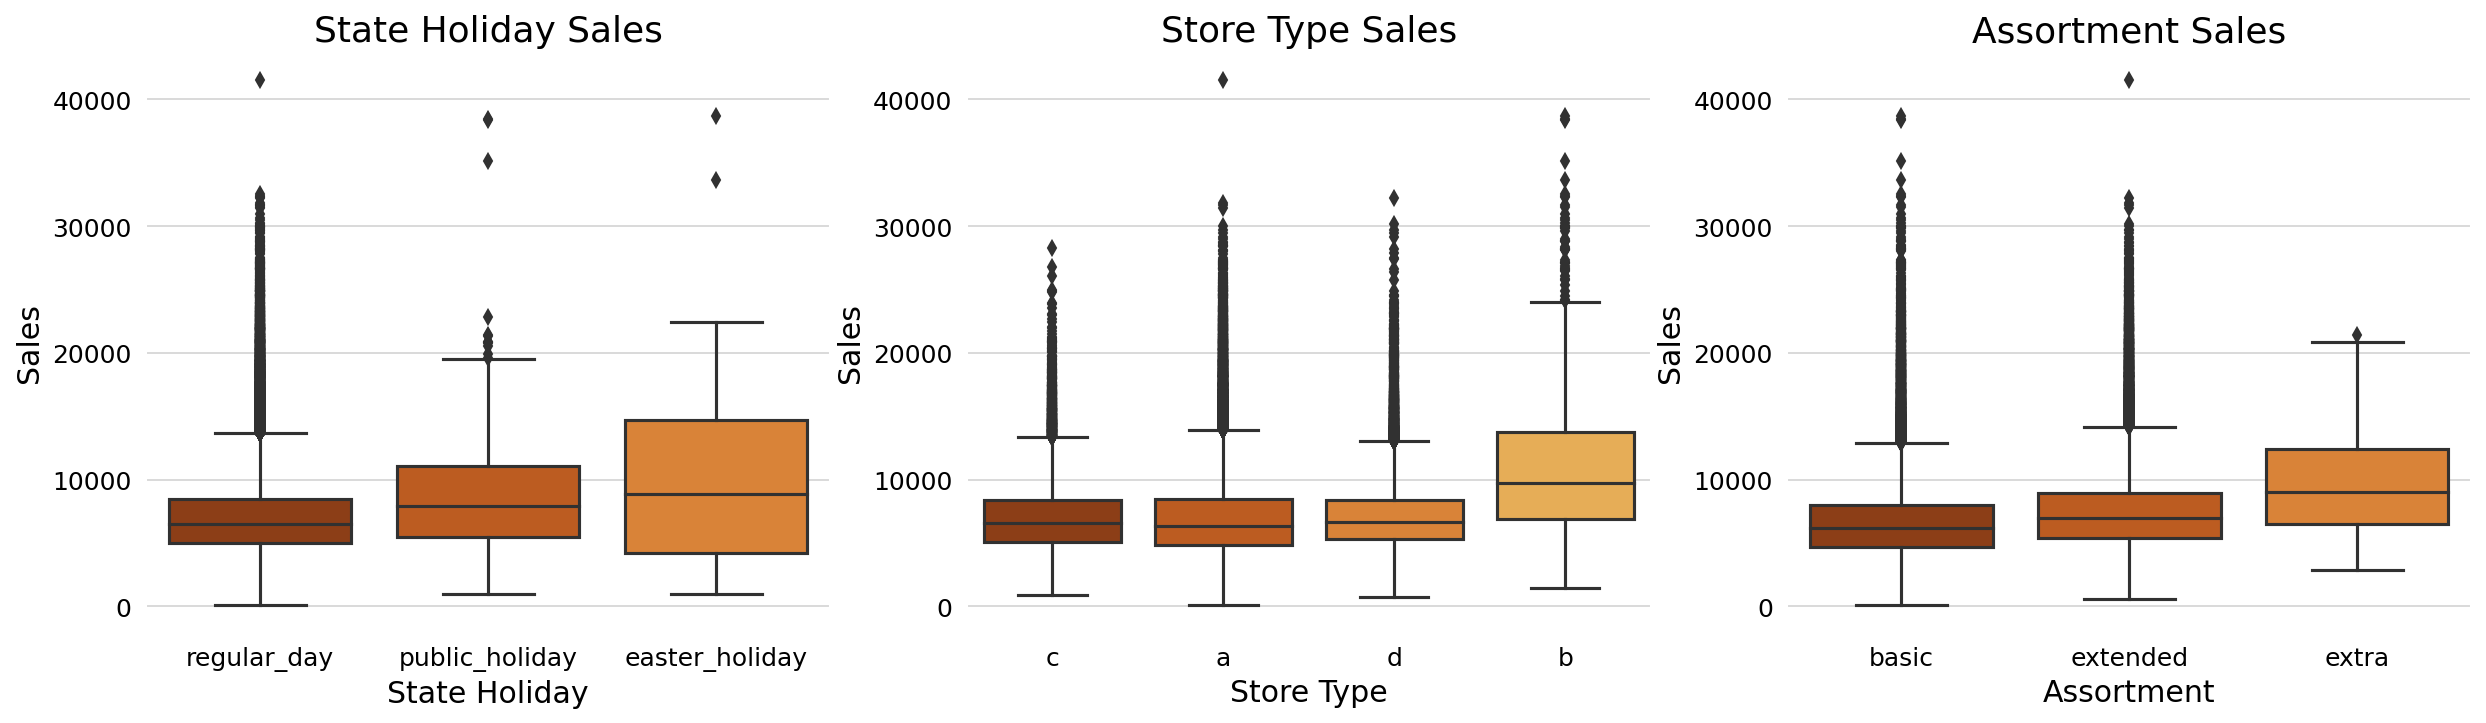

In [164]:
aux = df1[(df['sales'] > 0) & df1['state_holiday'] != 0]

fig_n, axes = plt.subplots(nrows=1, ncols=2)

plt.subplot( 1, 3, 1 )
ax1 = sns.boxplot(data= aux, x='state_holiday', y='sales')
set_image('State Holiday Sales', 'State Holiday', 'Sales')

plt.subplot( 1, 3, 2 )
ax2 = sns.boxplot(data= aux, x='store_type', y='sales')
set_image('Store Type Sales', 'Store Type', 'Sales')

plt.subplot( 1, 3, 3 )
ax3 = sns.boxplot(data= aux, x='assortment', y='sales')
set_image('Assortment Sales', 'Assortment', 'Sales')

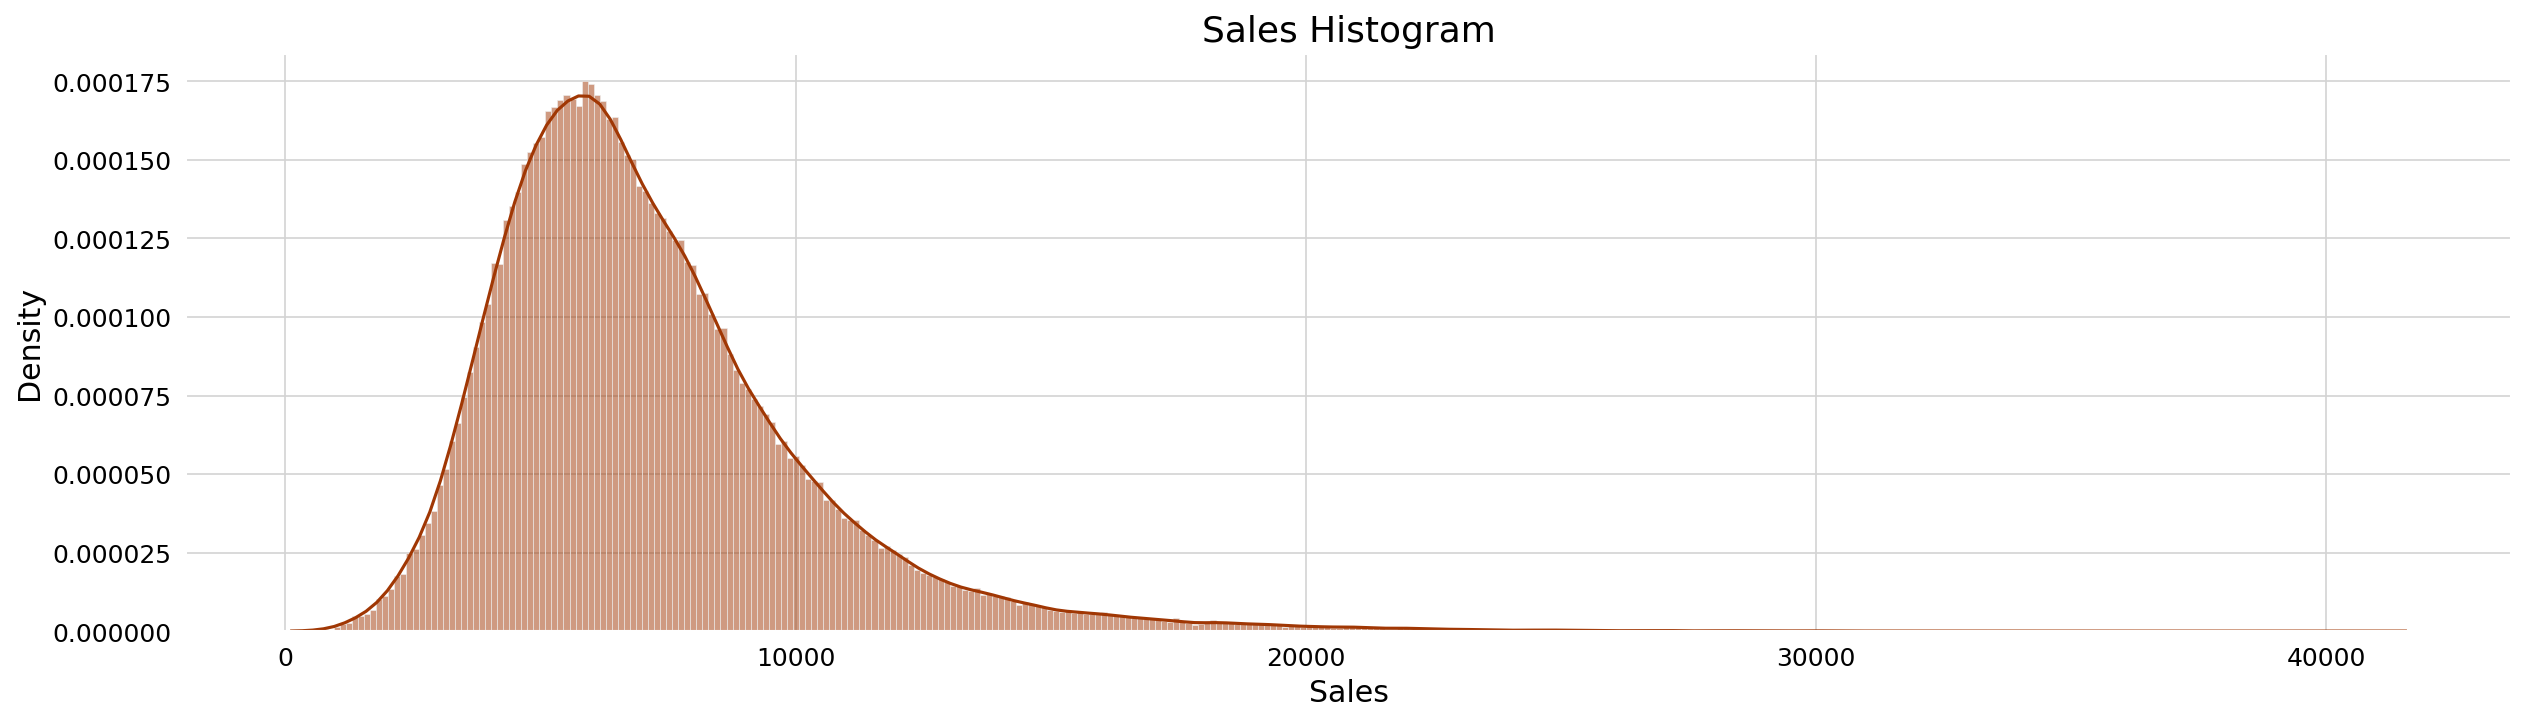

In [171]:
# Kernel Density Estimate (KDE) - Sales plot

# Sales histogram
sns.histplot(aux['sales'], kde=True, stat='density')
# Settings
set_image('Sales Histogram', 'Sales', 'Density')

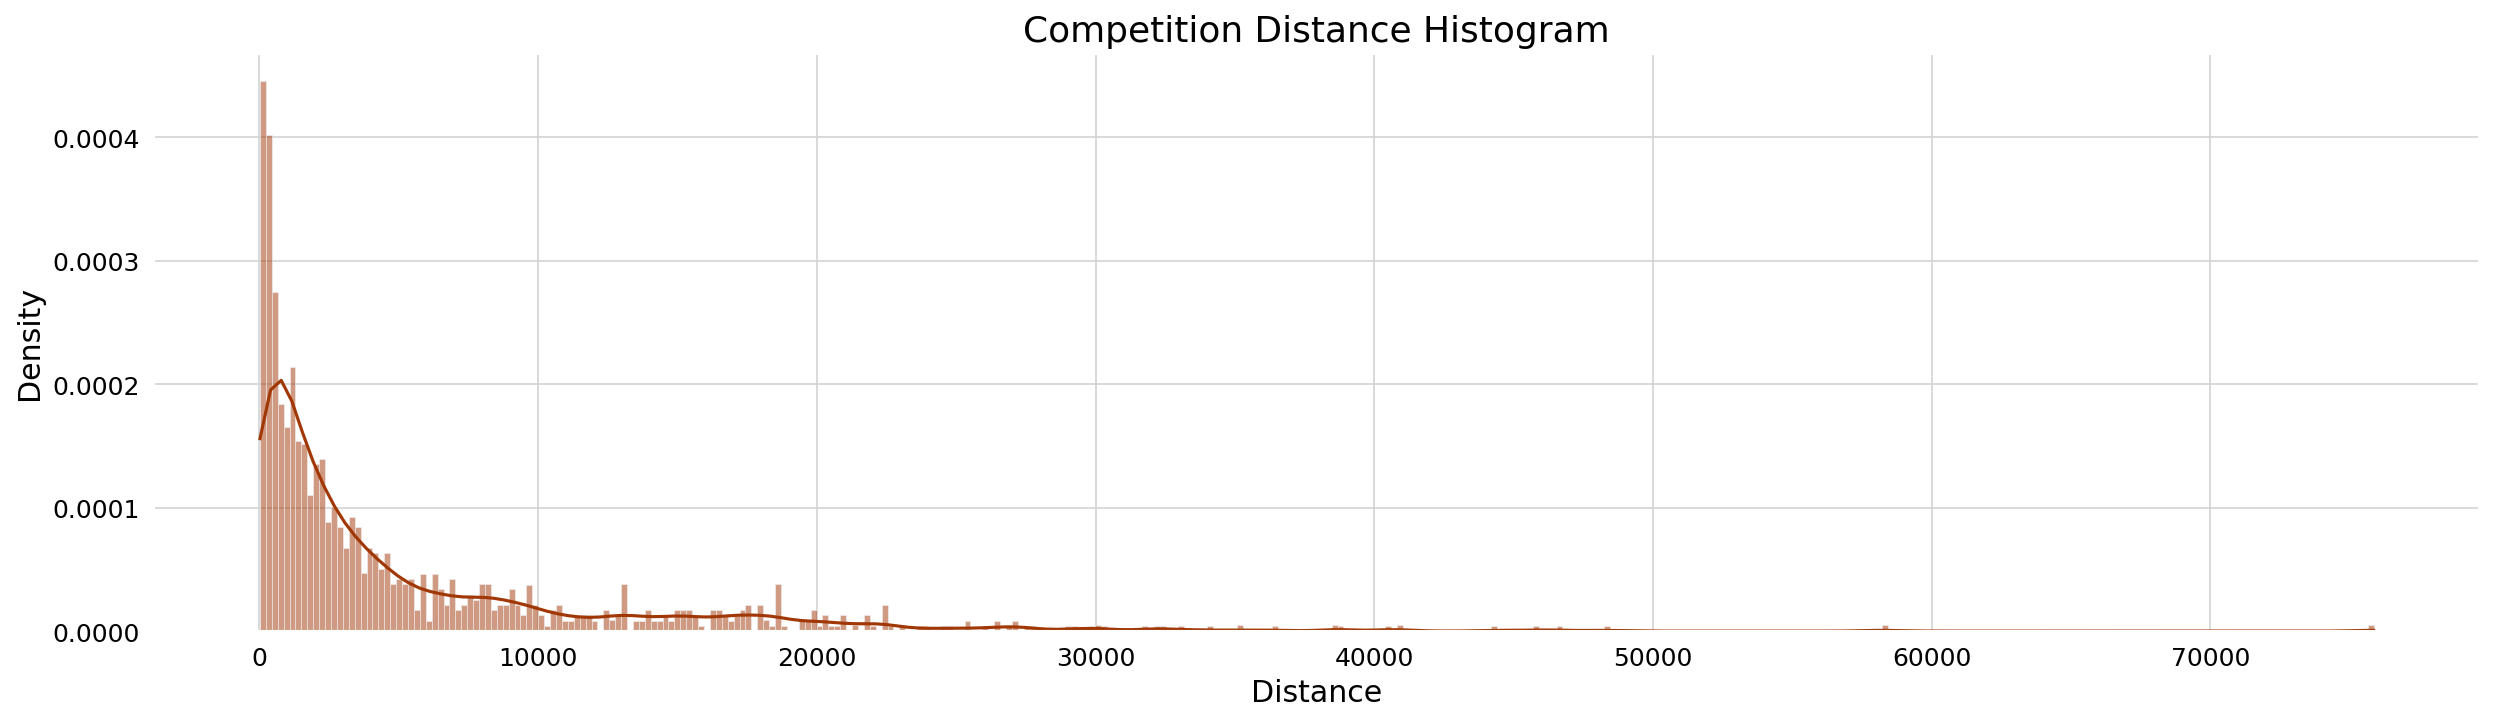

In [172]:
# Kernel Density Estimate (KDE) - Sales plot

sns.histplot(df1['comp_distance'], kde=True, stat='density')

set_image('Competition Distance Histogram', 'Distance', 'Density')

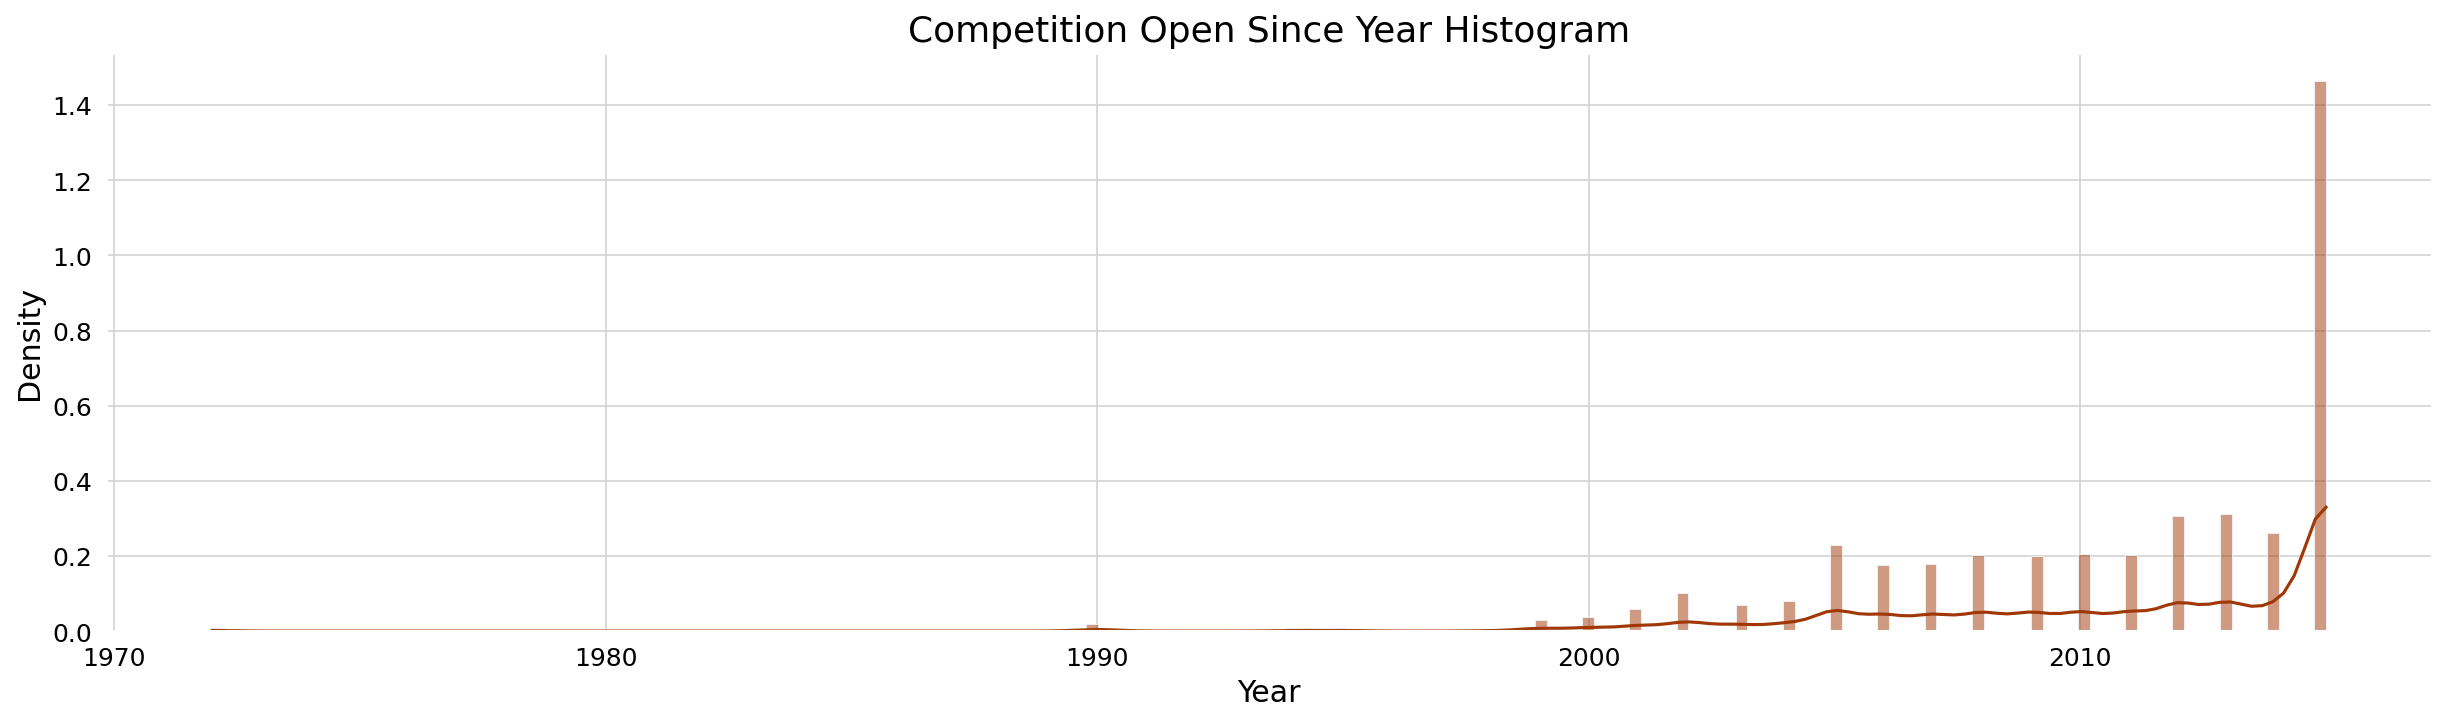

In [173]:
# Kernel Density Estimate (KDE) - Sales plot

sns.histplot(df1['comp_open_year'], kde=True, stat='density')

set_image('Competition Open Since Year Histogram', 'Year', 'Density')

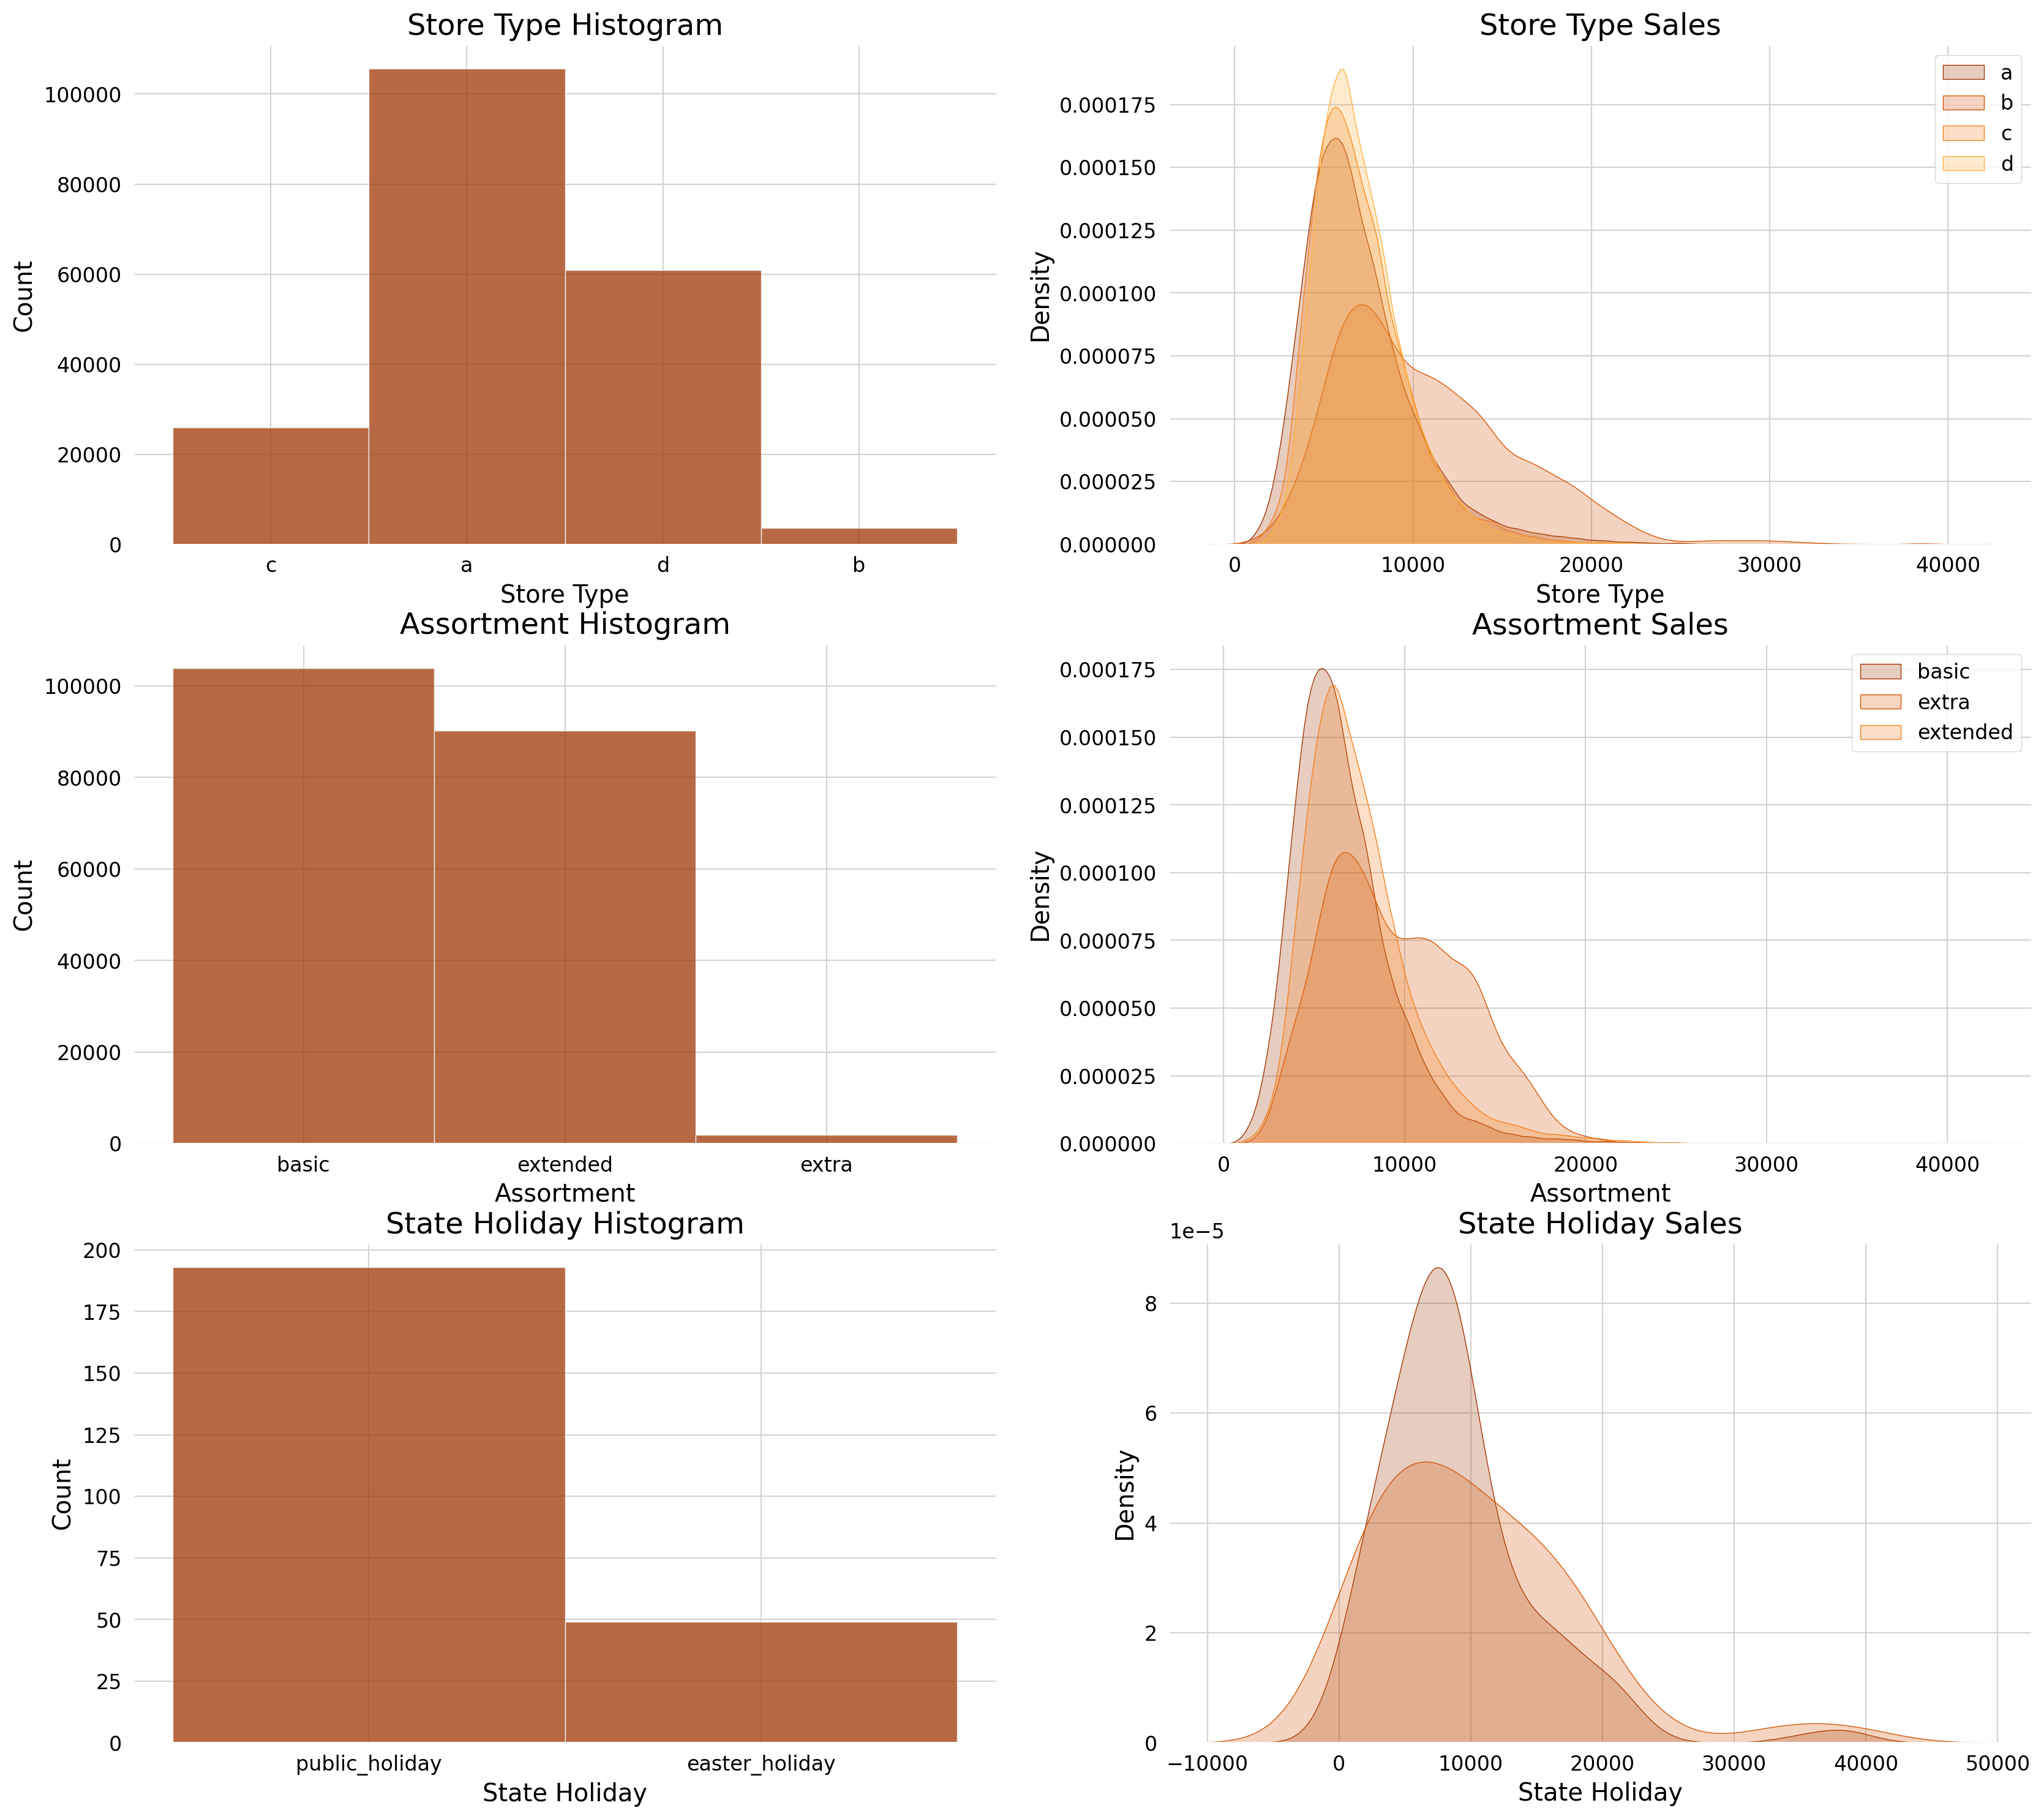

In [174]:
### Store Type

fig_n, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18), dpi=200)

# Histogram
plt.subplot(3, 2, 1)
sns.histplot(df1['store_type'])
set_image('Store Type Histogram', 'Store Type', 'Count')

# Density
plt.subplot(3, 2, 2)
sns.kdeplot(df1[df1['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df1[df1['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df1[df1['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df1[df1['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend(loc='upper right')
set_image('Store Type Sales', 'Store Type', 'Density')

### Assortment Level

# Histogram
plt.subplot(3, 2, 3)
sns.histplot(df1['assortment'])
set_image('Assortment Histogram', 'Assortment', 'Count')

# Density
plt.subplot(3, 2, 4)
sns.kdeplot(df1[df1['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df1[df1['assortment'] == 'extra']['sales'], label='extra', shade=True)
sns.kdeplot(df1[df1['assortment'] == 'extended']['sales'], label='extended', shade=True)
plt.legend(loc='upper right')
set_image('Assortment Sales', 'Assortment', 'Density')

### State Holiday
plt.subplot(3, 2, 5)
# Dropping 'regular_day'
df_aux = df1[df1['state_holiday'] != 'regular_day']
sns.histplot(df_aux['state_holiday'])
set_image('State Holiday Histogram', 'State Holiday', 'Count')

plt.subplot(3, 2, 6)
sns.kdeplot(df_aux[df_aux['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df_aux[df_aux['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
set_image('State Holiday Sales', 'State Holiday', 'Density')

### 5.2. Hypothesis Testing

##### **H1:** Stores with higher assortment level are supposed to sell more.

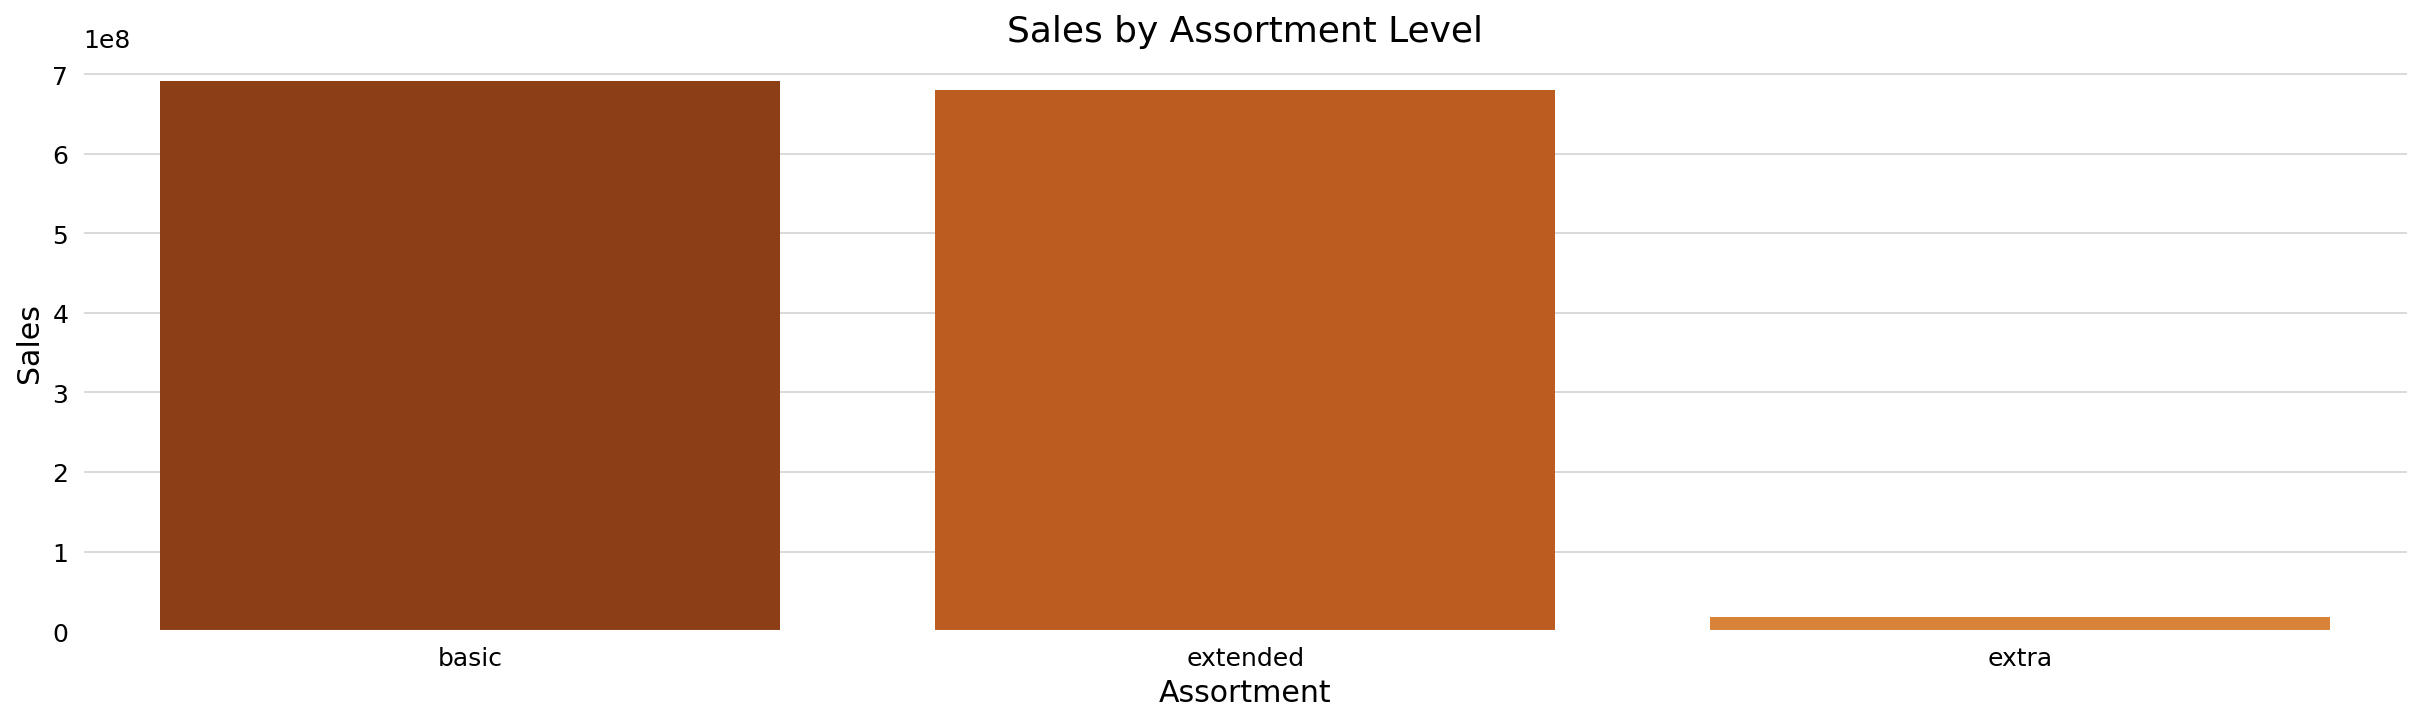

In [175]:
# Grouping Sales by Assortment Level
aux = df1[['assortment', 'sales']].groupby(['assortment']).sum().reset_index()

# Plotting
sns.barplot(data=aux, x='assortment', y='sales')

# Settings
set_image('Sales by Assortment Level', 'Assortment', 'Sales')

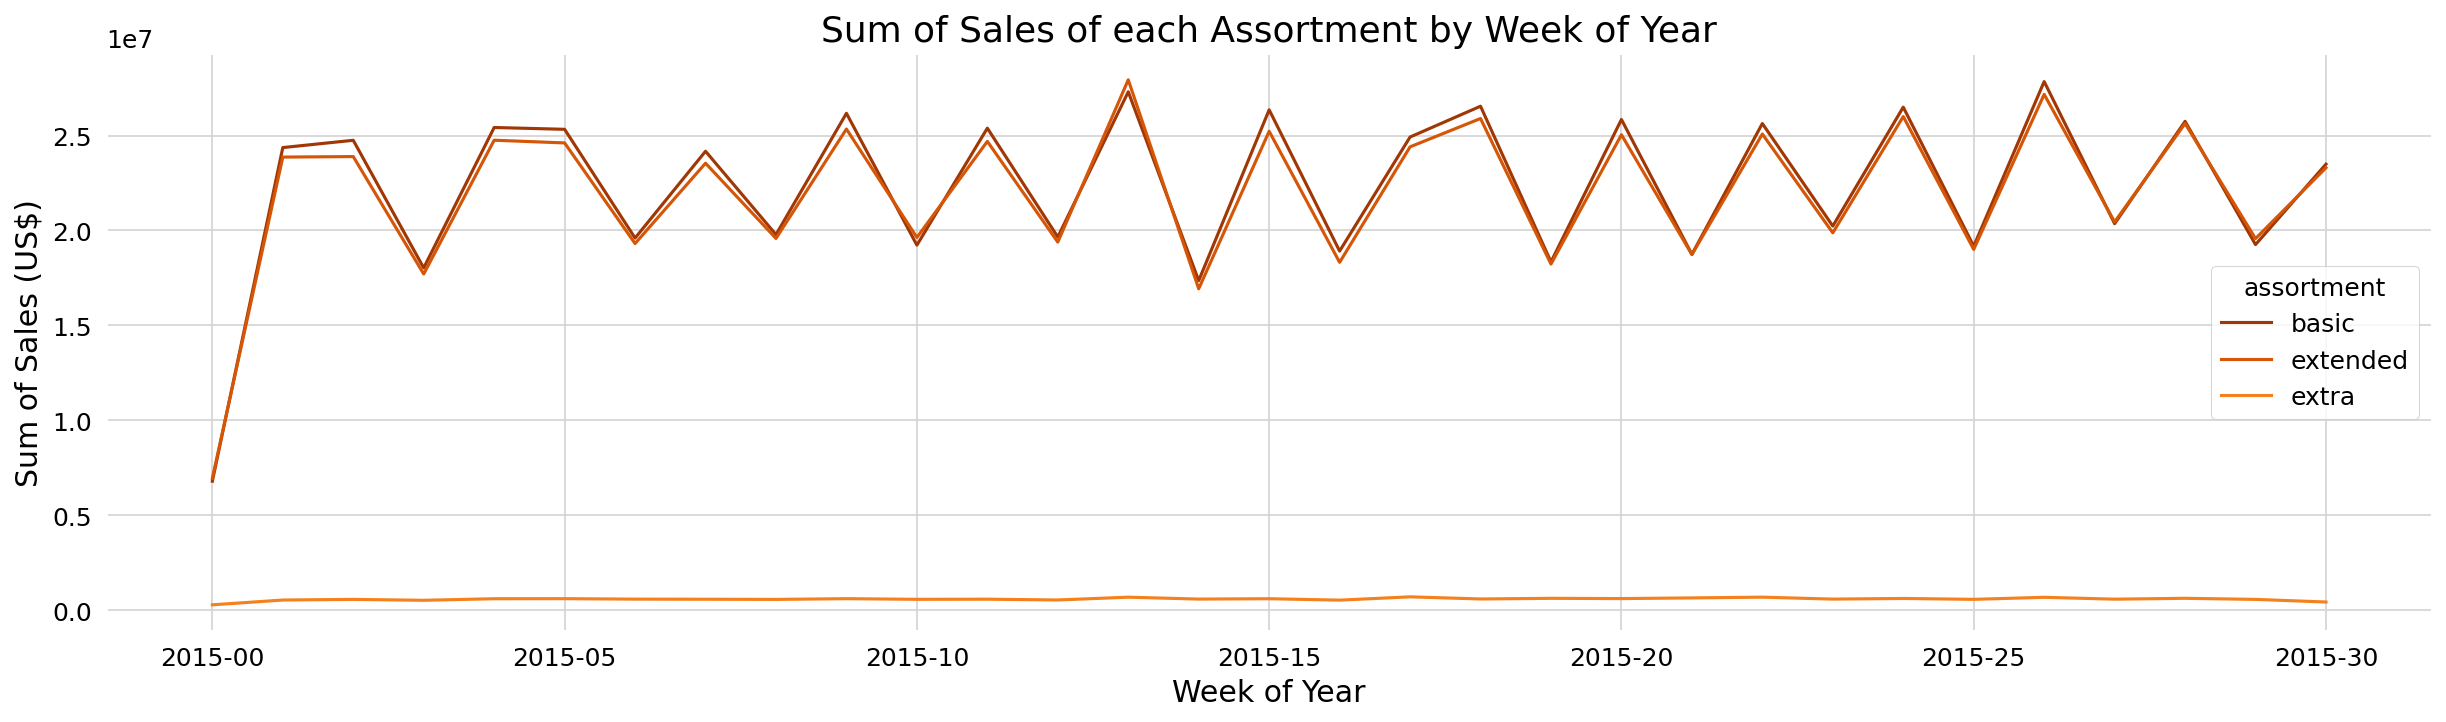

In [176]:
# Assortment Time Series

df_assort = df1[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

df_assort.pivot(index='year_week', columns='assortment', values='sales').plot()

set_image('Sum of Sales of each Assortment by Week of Year', 'Week of Year', 'Sum of Sales (US$)')

Because the extra assortment differs significantly from the other two scales, it is crucial to plot the extra assortment separately:

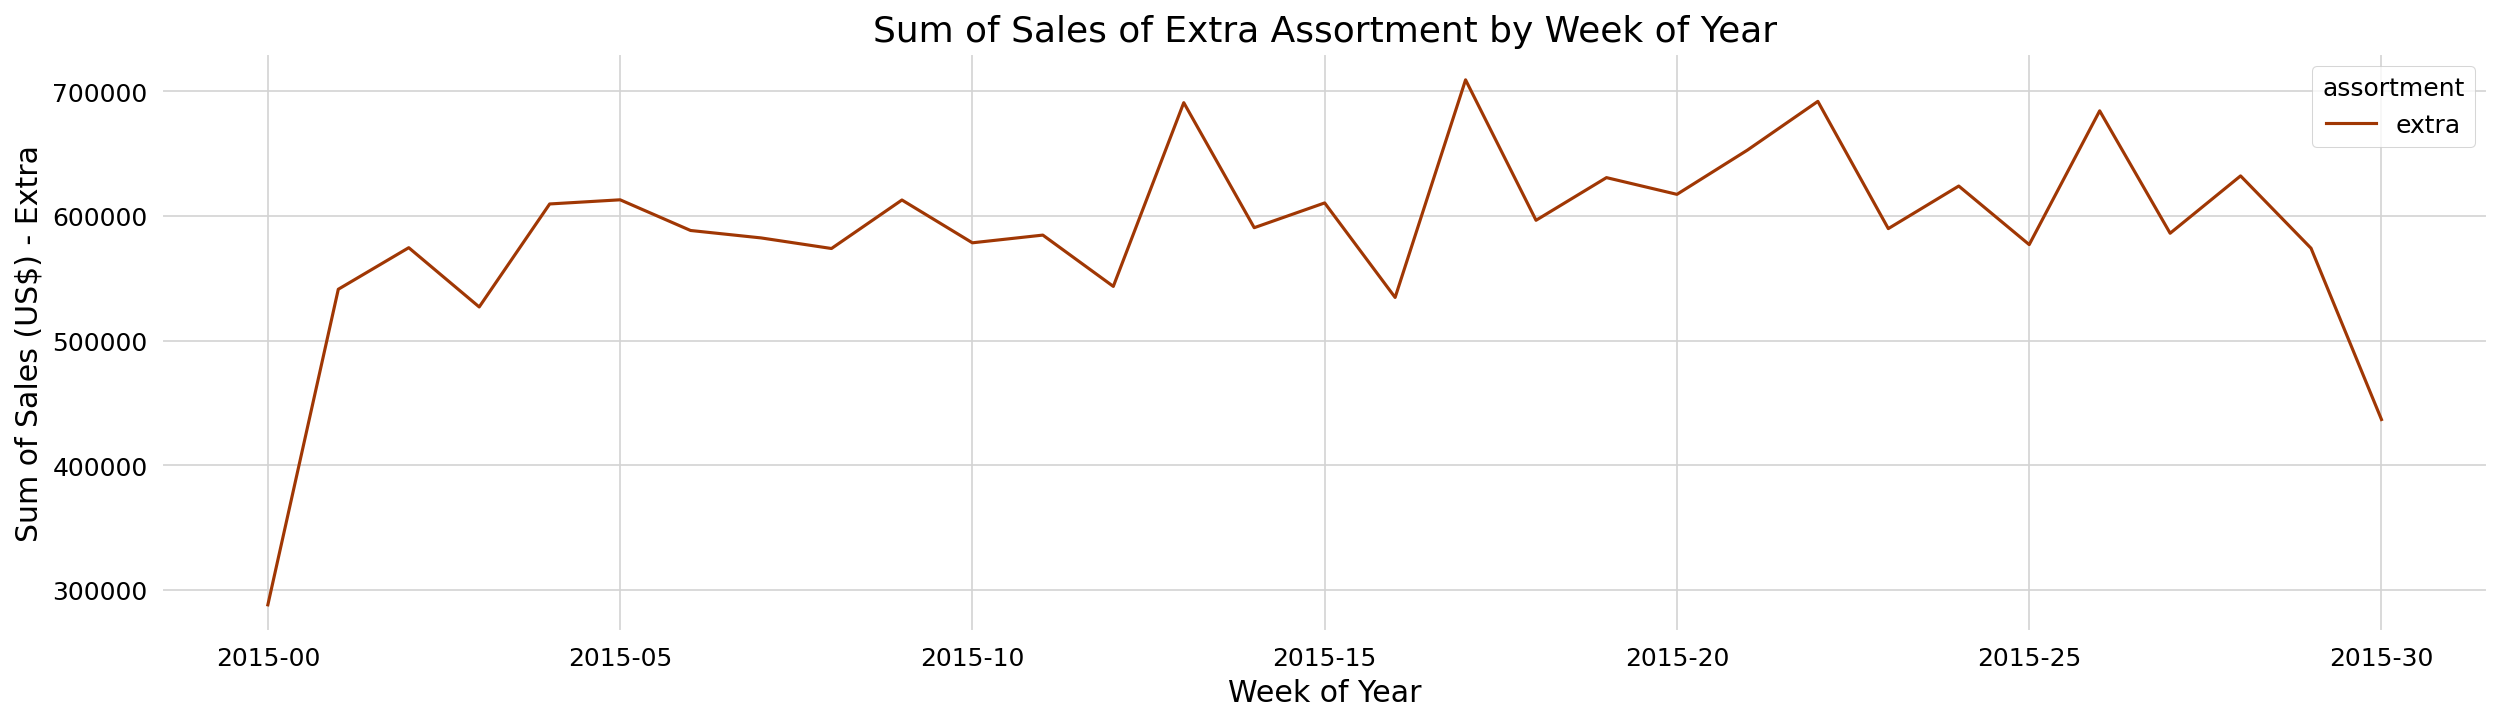

In [177]:
df_assort2 = df_assort[df_assort['assortment'] == 'extra']

df_assort2.pivot(index='year_week', columns='assortment', values='sales').plot()

set_image('Sum of Sales of Extra Assortment by Week of Year', 'Week of Year', 'Sum of Sales (US$) - Extra')

##### **H2:** Stores with higher number of nearby competitors are supposed to sell less.

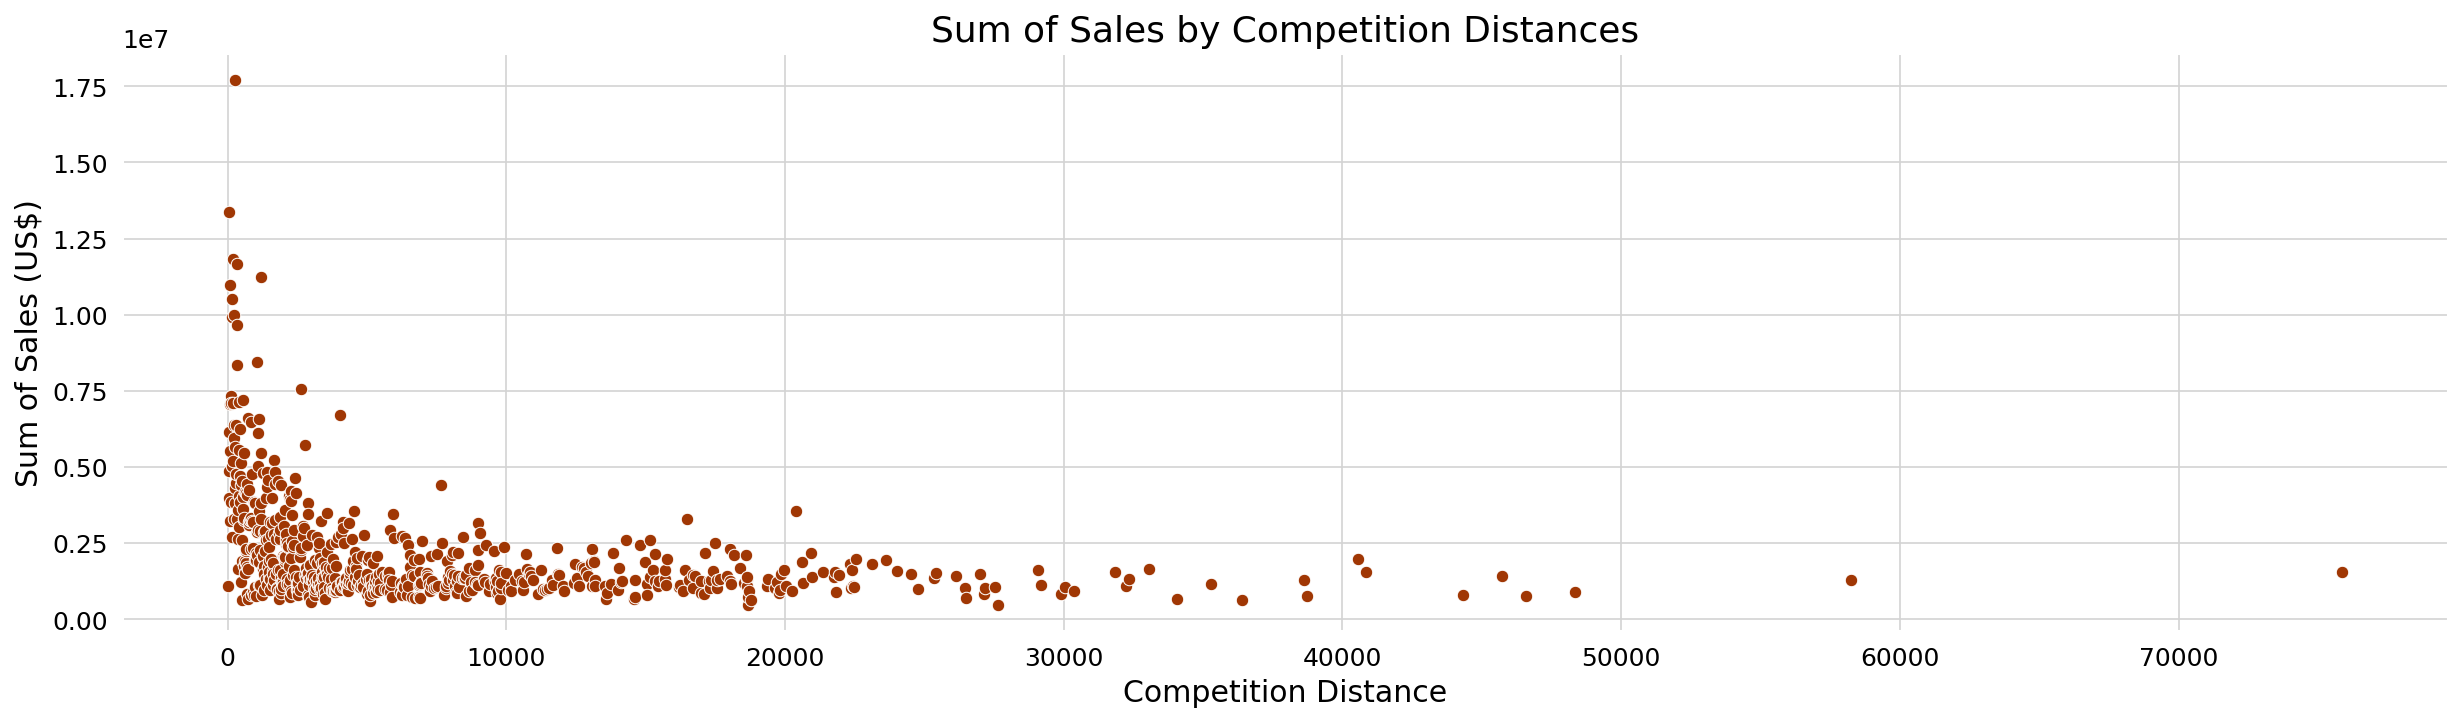

In [178]:
# Grouping sales by competition distances
aux = df1[['comp_distance', 'sales']].groupby(['comp_distance']).sum().reset_index() 

sns.scatterplot(data=aux, x ='comp_distance', y='sales')

set_image('Sum of Sales by Competition Distances', 'Competition Distance', 'Sum of Sales (US$)')

#### **H3:** Stores with competitors for a longer period of time sell more.

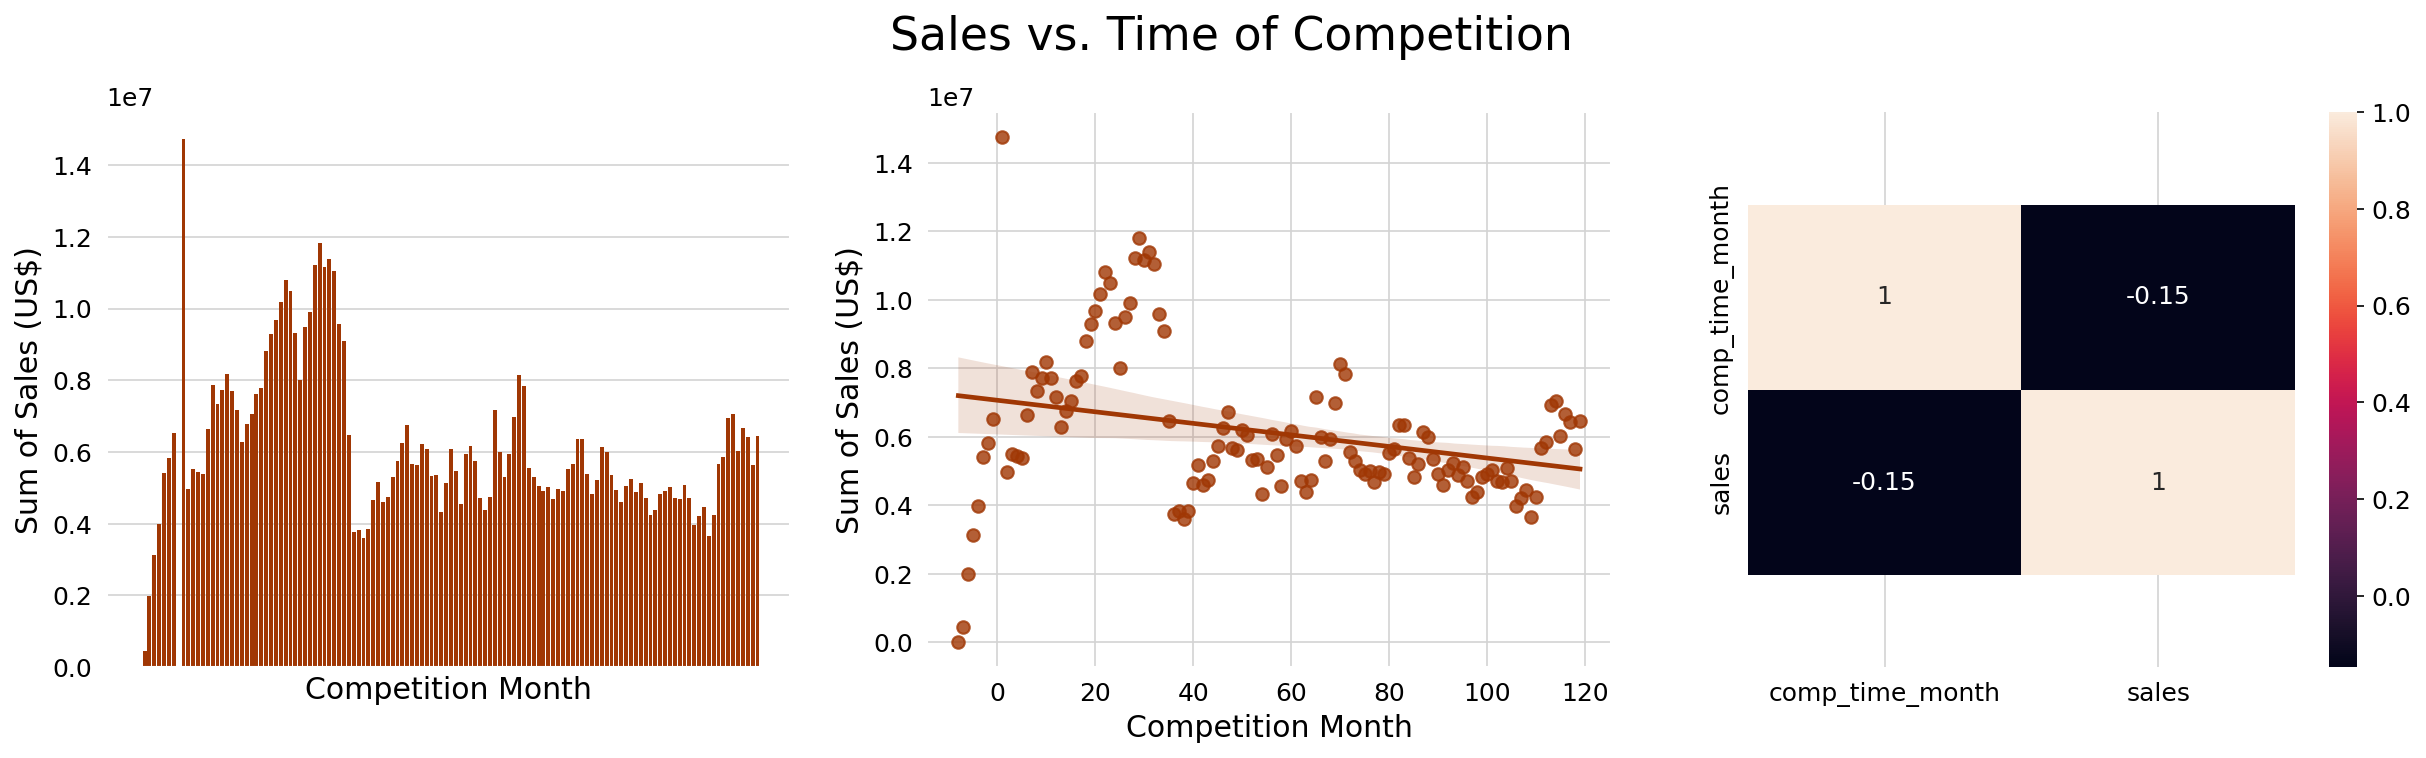

In [179]:
# Creating figure
fig_h3, axes = plt.subplots(nrows=1, ncols=3)

# Setting title for main figure
fig_h3.suptitle('Sales vs. Time of Competition', fontsize=22)

# Adjusting spacing
fig_h3.subplots_adjust(top=0.85)

plt.subplot( 1, 3, 1 )
aux1 = df1[['comp_time_month', 'sales']].groupby(['comp_time_month']).sum().reset_index()
aux2 = aux1[(aux1['comp_time_month'] < 120) & (aux1['comp_time_month'] != 0)]
plt.bar(data=aux2, x='comp_time_month', height='sales')
plt.xticks([])
set_image(None, 'Competition Month', 'Sum of Sales (US$)')

plt.subplot( 1, 3, 2 )
sns.regplot(data=aux2, x='comp_time_month', y='sales')
set_image(None, 'Competition Month', 'Sum of Sales (US$)')

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5)
set_image(None, None, None)

#### **H4:** Stores that keep promotions for longer periods are supposed to sell more.

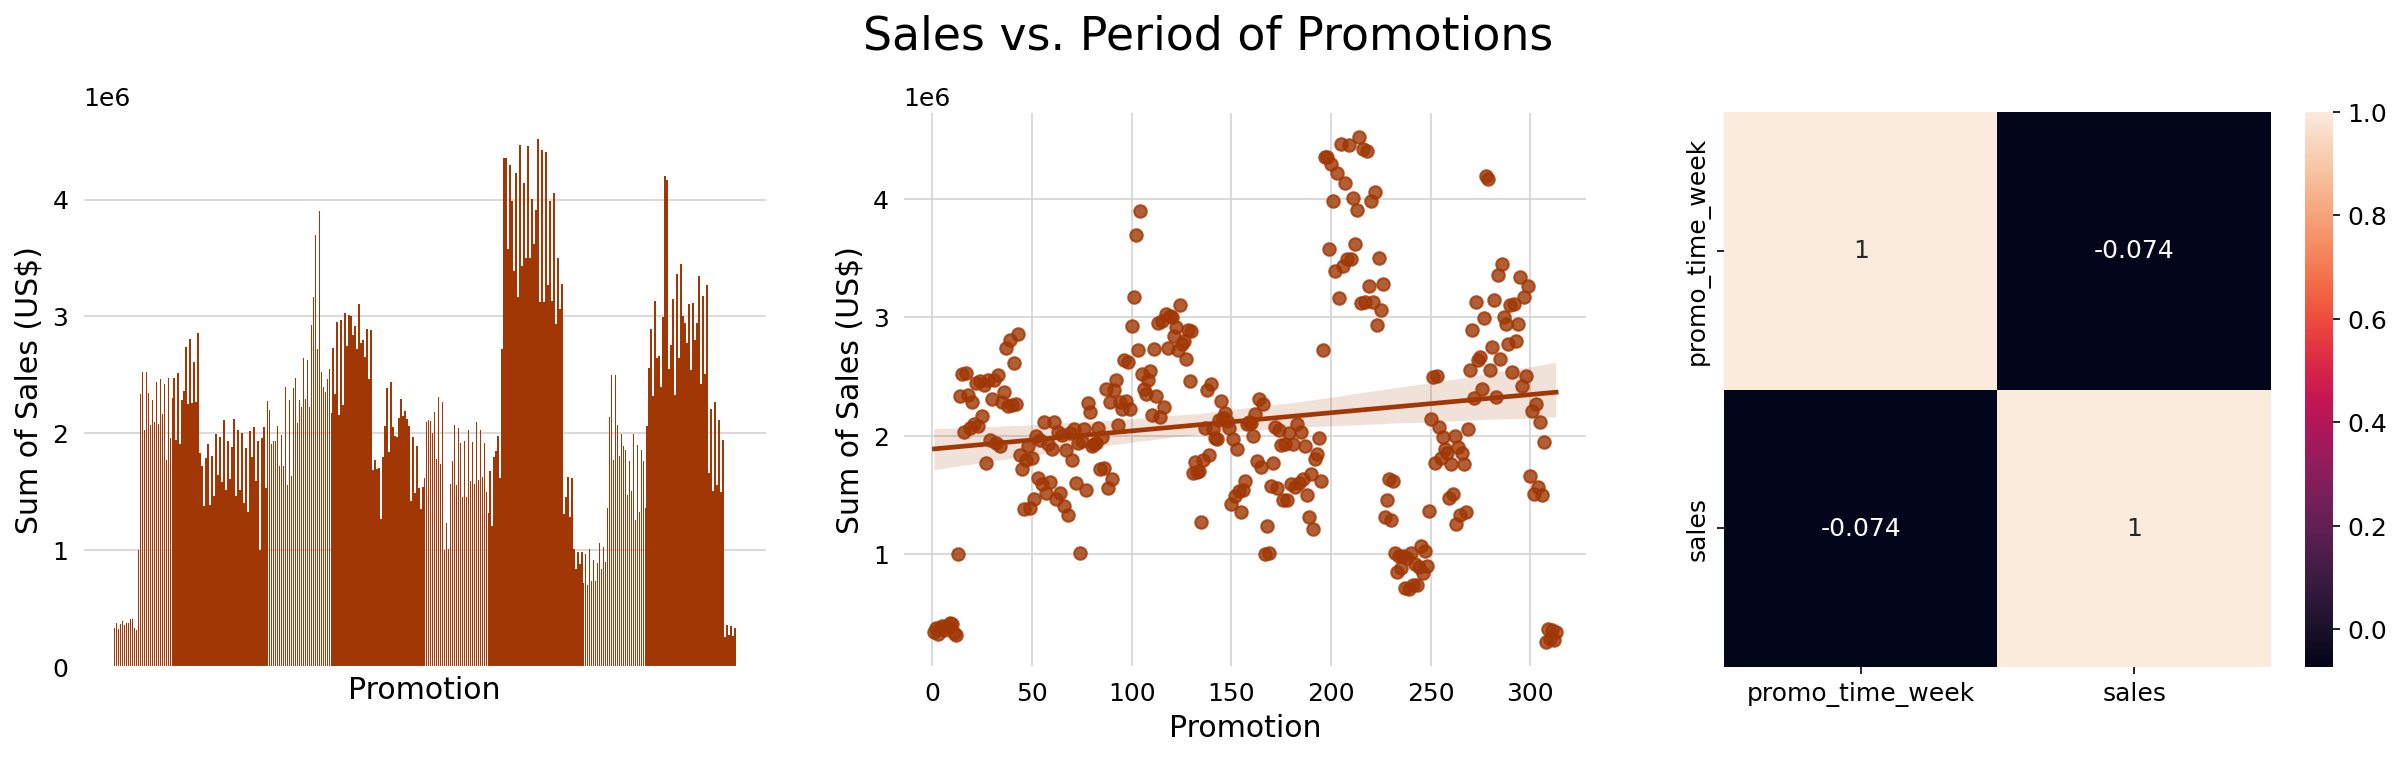

In [180]:
# Creating figure
fig_h4, axes = plt.subplots(nrows=1, ncols=3)

# Setting title for main figure
fig_h4.suptitle('Sales vs. Period of Promotions', fontsize=22)

# Adjusting spacing
fig_h4.subplots_adjust(top=0.85)

# Promotion time
aux1 = df1[['promo_time_week', 'sales']].groupby(['promo_time_week']).sum().reset_index()

# Subplots
plt.subplot(1,3,1)
aux2 = aux1[aux1['promo_time_week'] > 0] 
plt.bar(data=aux2, x='promo_time_week', height='sales')
plt.xticks([])
set_image(None, 'Promotion', 'Sum of Sales (US$)')

plt.subplot(1,3,2)
sns.regplot(data=aux2, x='promo_time_week', y='sales')
set_image(None, 'Promotion', 'Sum of Sales (US$)')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);


#### **H5:** Stores that participate in more consecutive promotions are supposed to sell more.

In [181]:
df1[['sales','promo2','promo']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,329304531
1,0,1,301433863
2,1,0,388797436
3,1,1,369963813


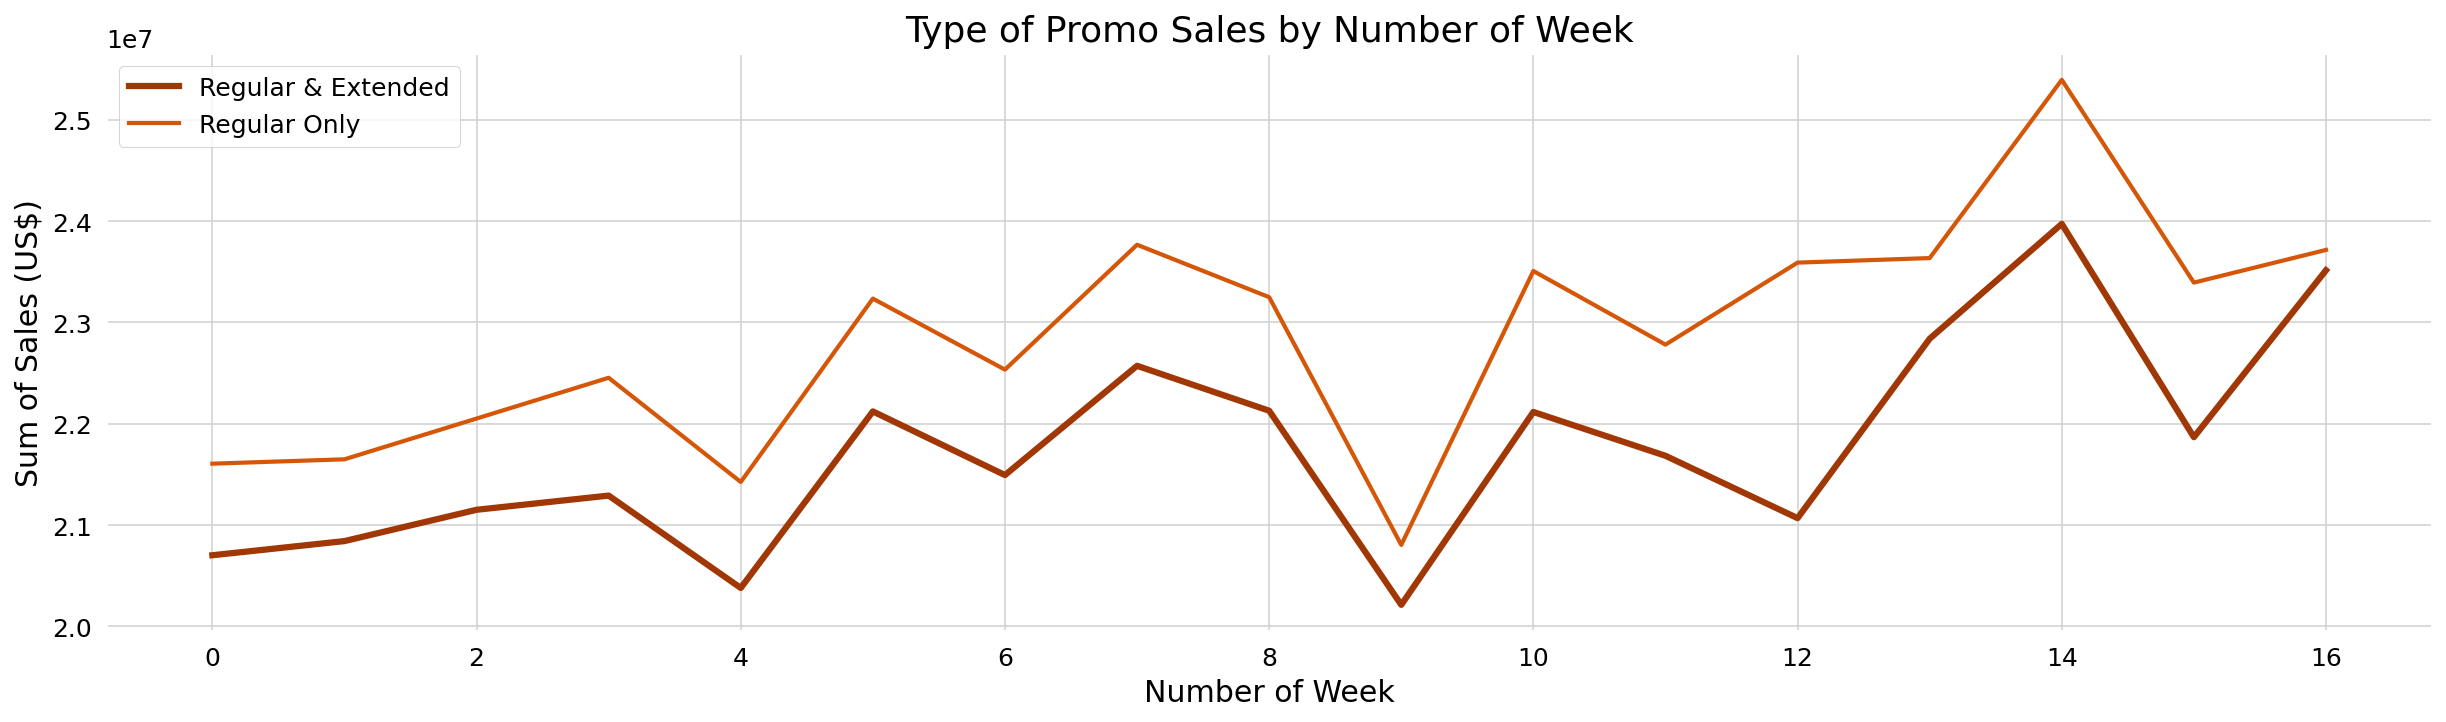

In [182]:
aux1 = df1[(df1['promo'] == 1) & (df1['promo2'] == 1)][['year_week','sales']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot(linewidth=3)

aux2 = df1[(df1['promo'] == 1) & (df1['promo2'] == 0)][['year_week','sales']].groupby(['year_week']).sum().reset_index()
aux2.plot(ax=ax, linewidth=2)

ax.legend(labels=['Regular & Extended', 'Regular Only'])

set_image('Type of Promo Sales by Number of Week', 'Number of Week', 'Sum of Sales (US$)')

#### **H6:** Regular days sell less than holidays on average.

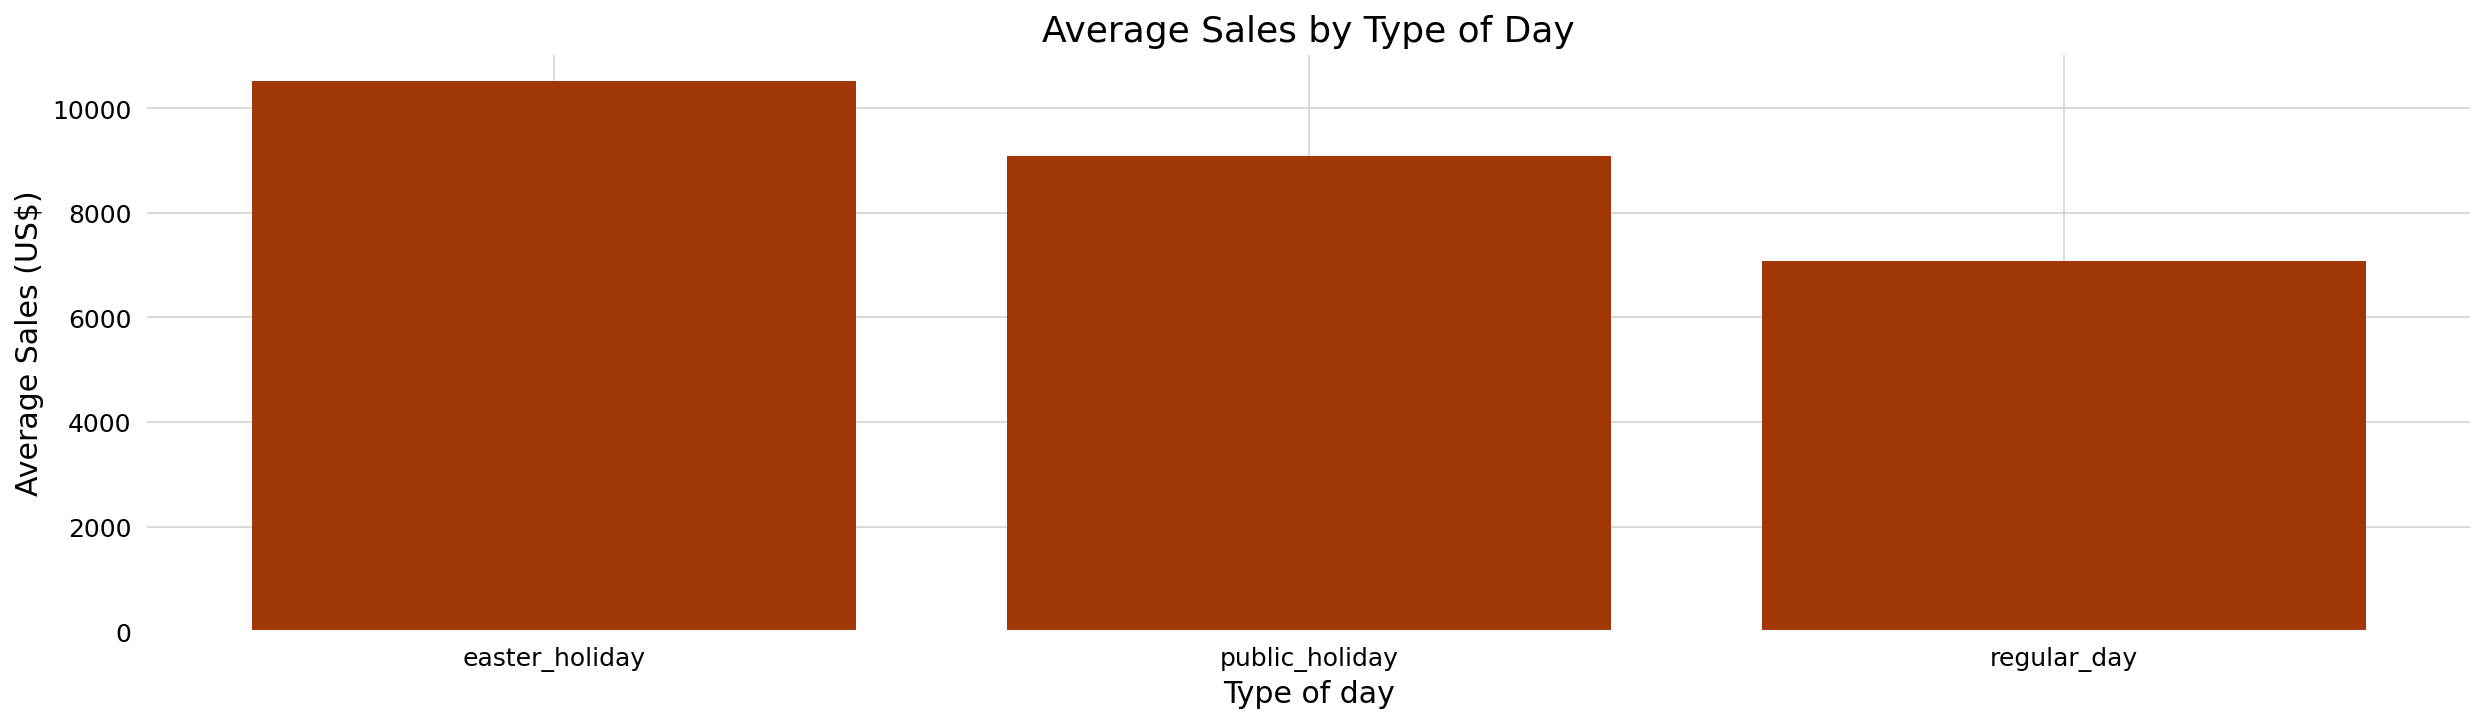

In [183]:
# Setting dataframe
aux1 = df1[['state_holiday','sales']].groupby(['state_holiday']).mean().reset_index()
aux1 = aux1.sort_values('sales', ascending=False)
# Plotting
plt.bar(data=aux1, x='state_holiday', height='sales')
# Settings
set_image('Average Sales by Type of Day', 'Type of day', 'Average Sales (US$)')

#### **H7:** Stores are supposed to sell more before the 15th day of each month.

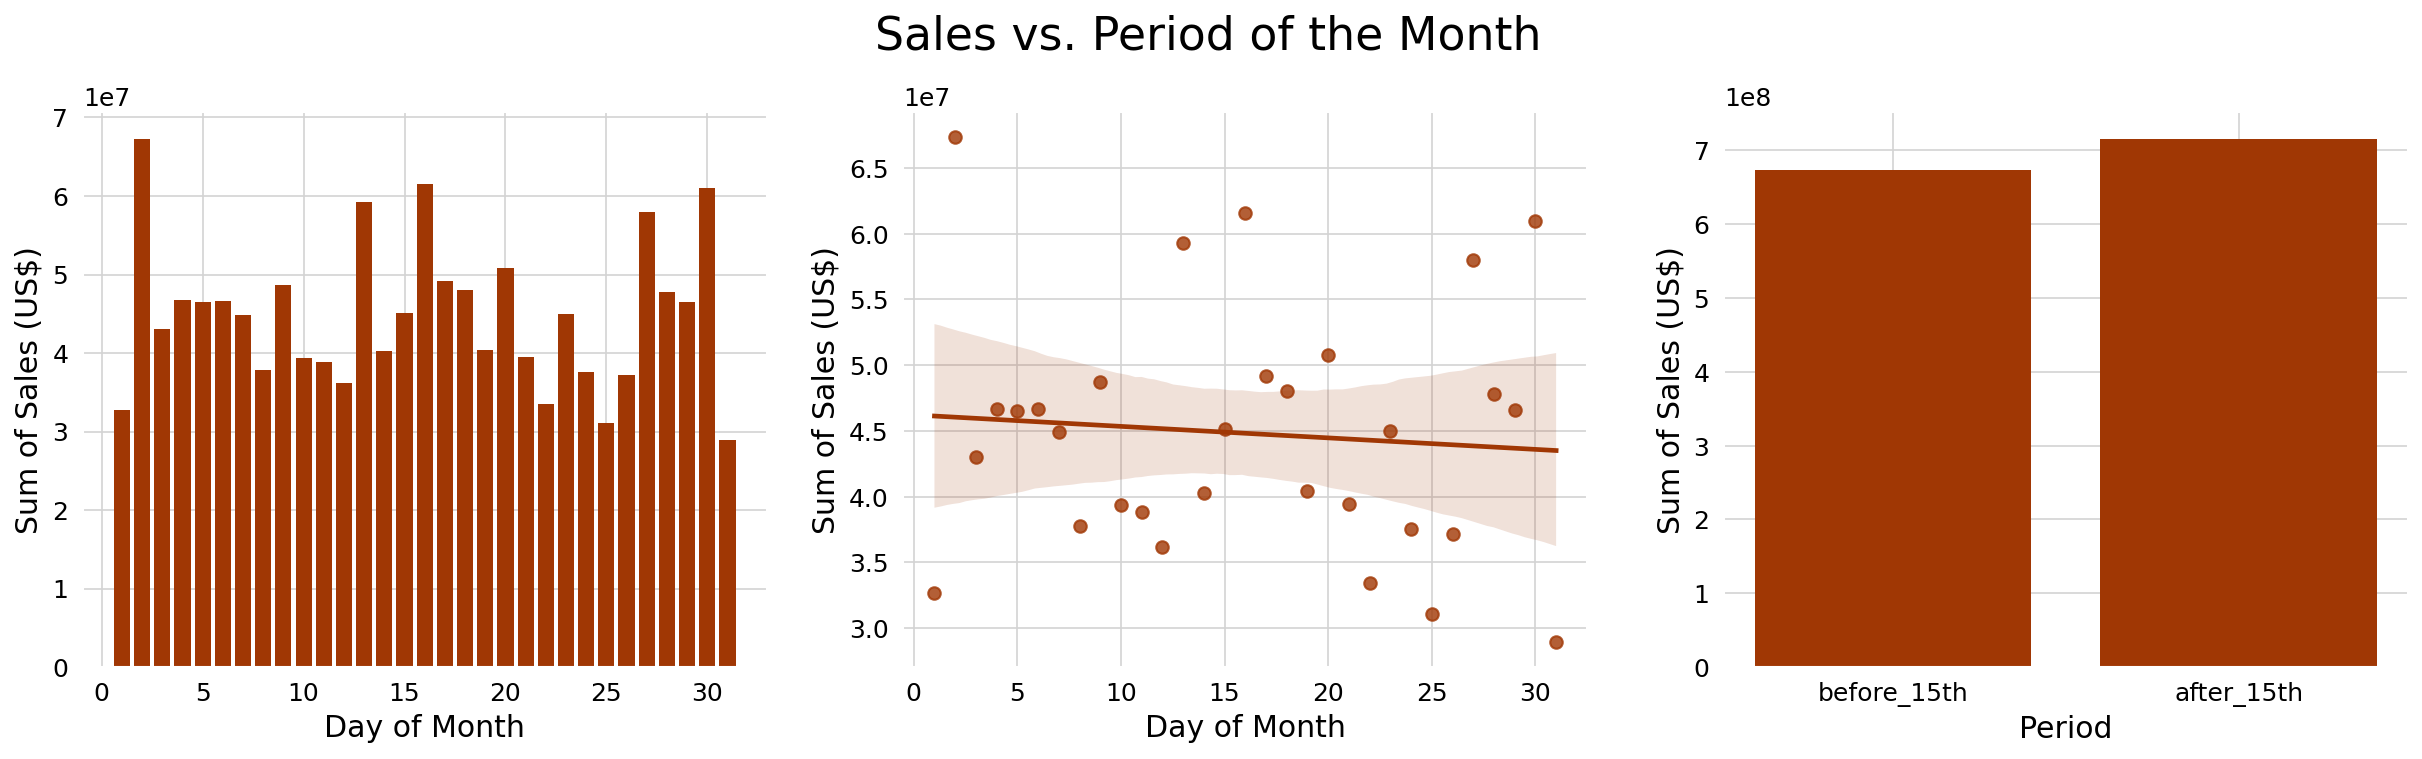

In [184]:
# Creating figure
fig_h9, axes = plt.subplots(nrows=1, ncols=3)

# Setting title for main figure
fig_h9.suptitle('Sales vs. Period of the Month', fontsize=22)

# Adjusting spacing
fig_h9.subplots_adjust(top=0.85)

# Manipulating data
aux1 = df1[df1['day']<=15][['sales']].sum()
aux2 = df1[df1['day']>15][['sales']].sum()
aux3 = pd.DataFrame({'before_15th':aux1, 'after_15th':aux2}).T.reset_index().rename({'index':'period'},axis=1) 
aux4 = df1[['day','sales']].groupby(['day']).sum().reset_index() 

plt.subplot(1,3,1)
plt.bar(data=aux4, x='day', height='sales')
set_image(None, 'Day of Month', 'Sum of Sales (US$)')

plt.subplot(1,3,2)
sns.regplot(data=aux4, x='day', y='sales')
set_image(None, 'Day of Month', 'Sum of Sales (US$)')

plt.subplot(1,3,3)
plt.bar(data=aux3, x='period', height='sales')
set_image(None, 'Period', 'Sum of Sales (US$)')

#### **H8:** Stores are supposed to sell less during the weekend on average.

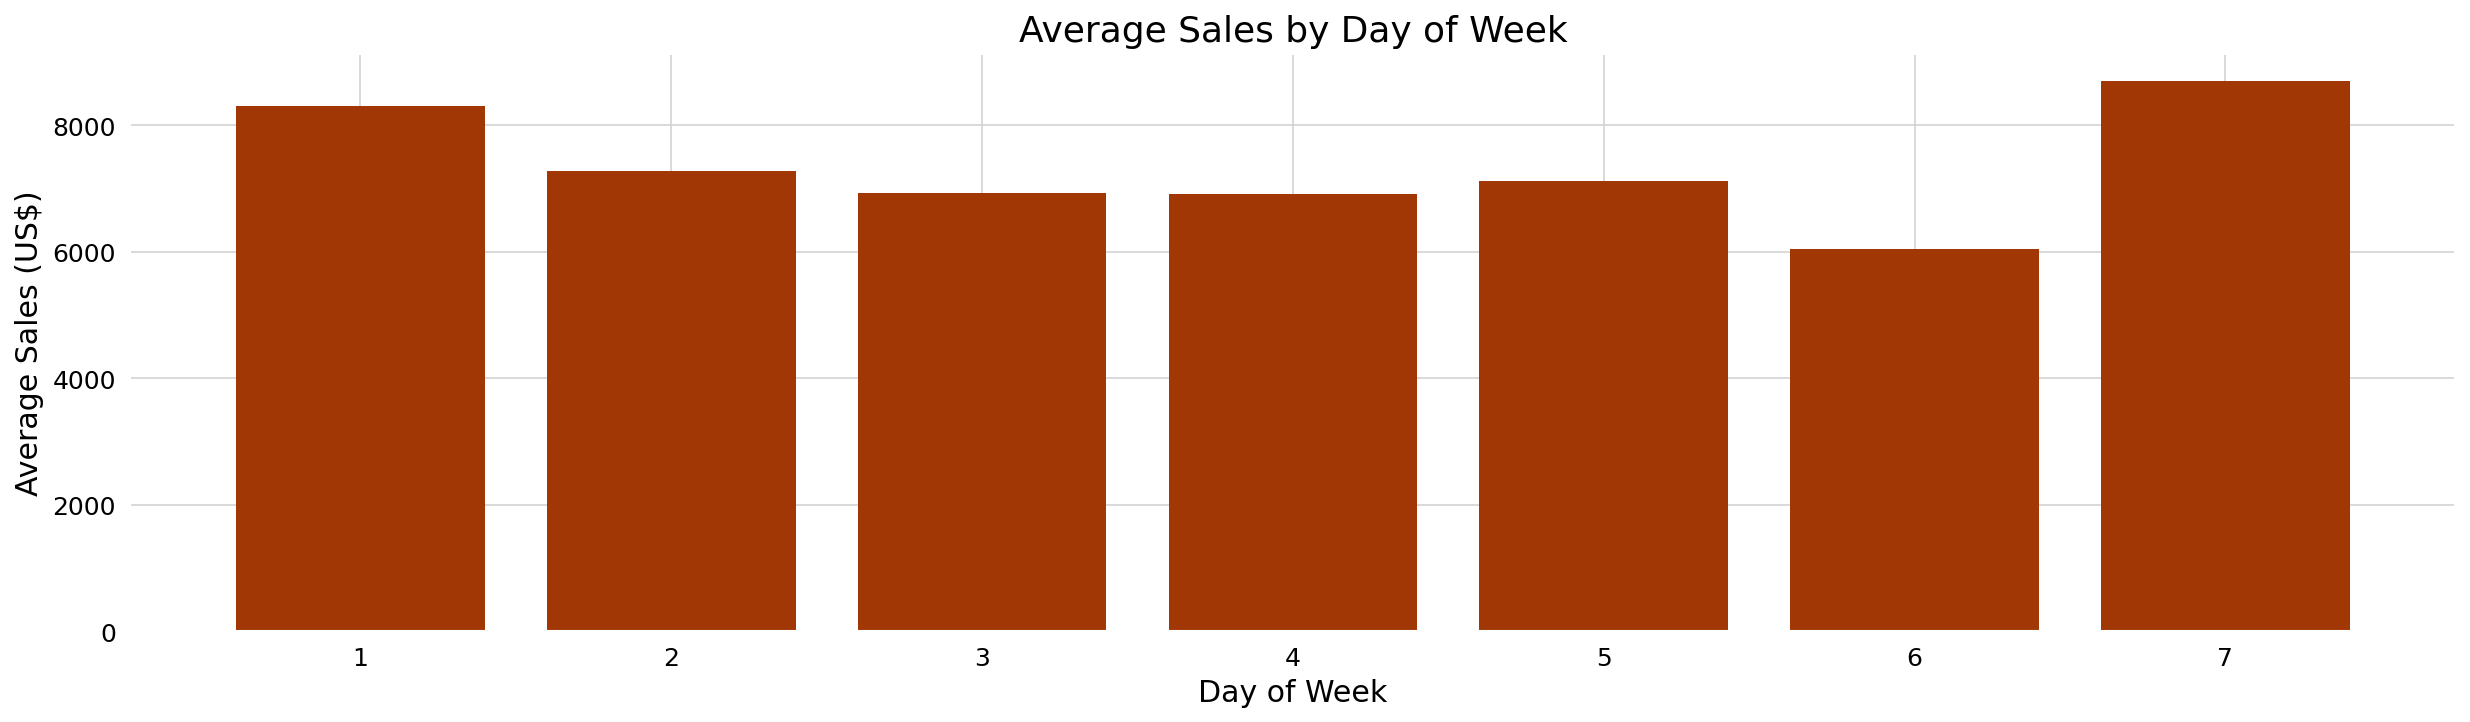

In [185]:
aux1 = df1[['day_of_week','sales']].groupby(['day_of_week']).mean().reset_index()
plt.bar(data=aux1, x='day_of_week', height='sales')
set_image('Average Sales by Day of Week', 'Day of Week', 'Average Sales (US$)')

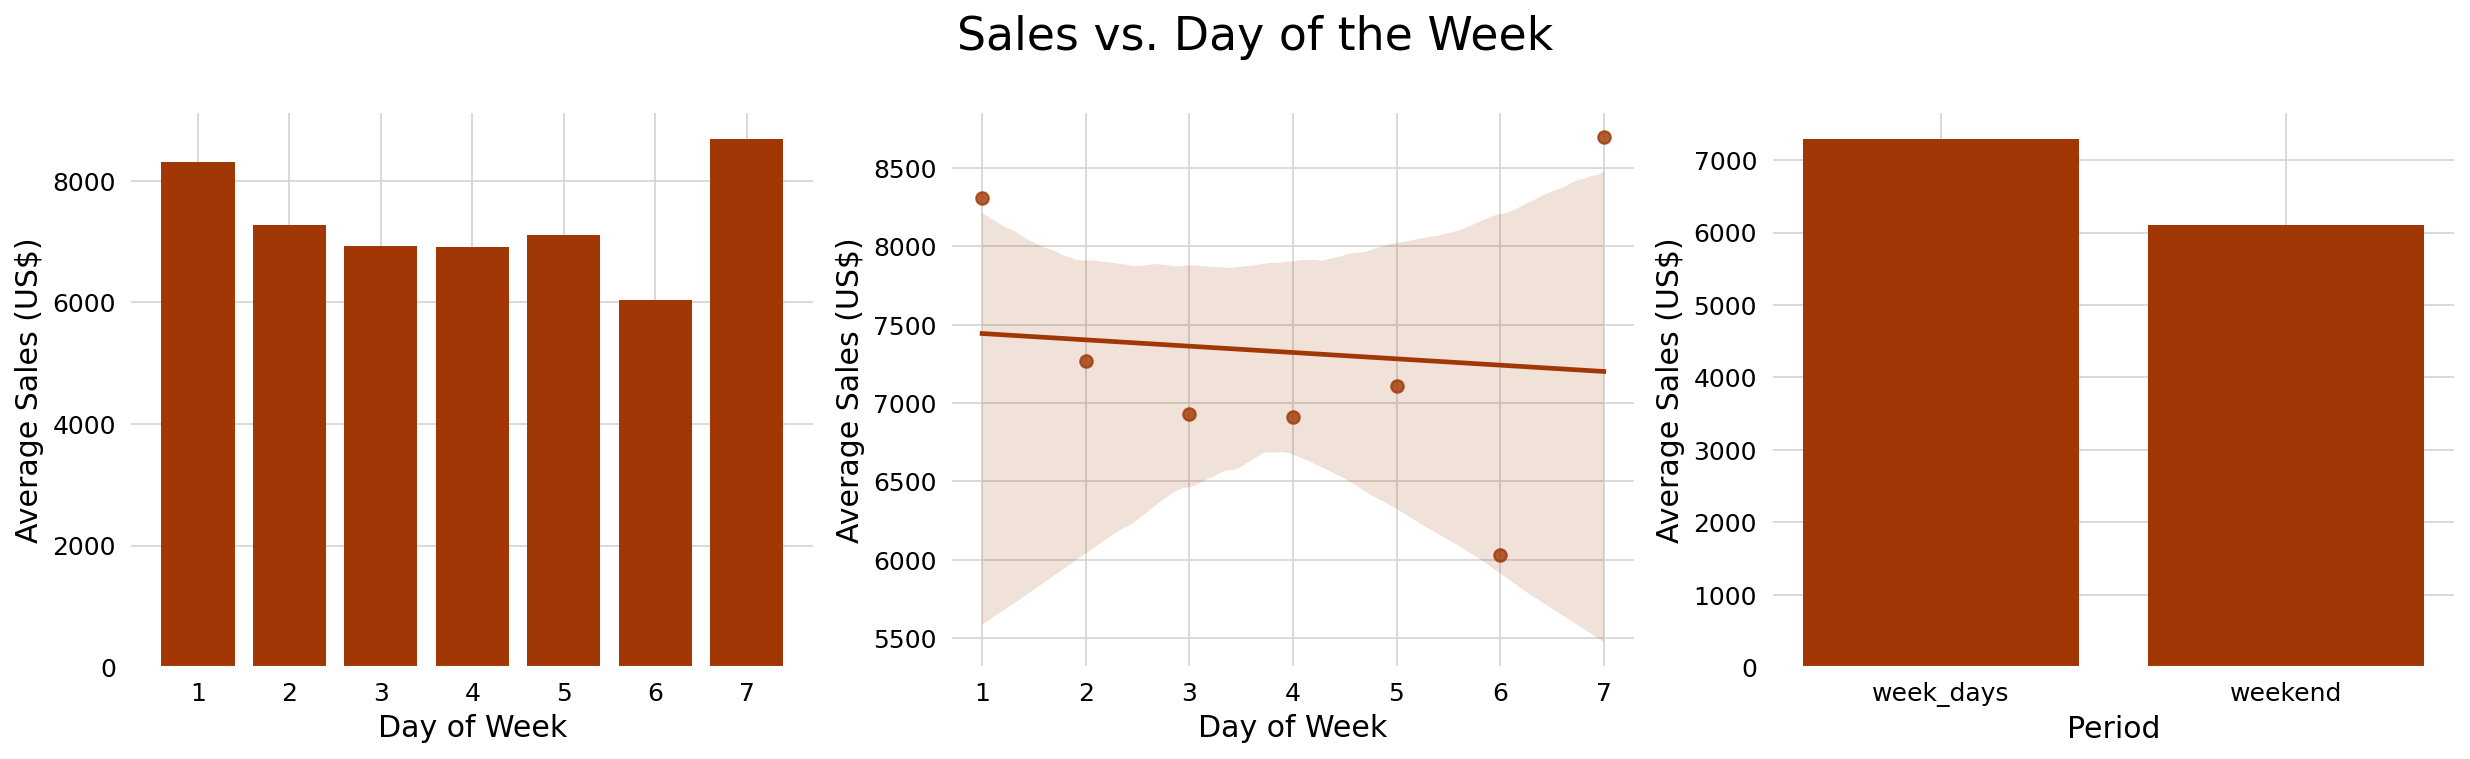

In [186]:
# Creating figure
fig_h10, axes = plt.subplots(nrows=1, ncols=3)

# Setting title for main figure
fig_h10.suptitle('Sales vs. Day of the Week', fontsize=22)

# Adjusting spacing
fig_h10.subplots_adjust(top=0.85)

aux1 = df1[df1['day_of_week']<=5][['sales']].mean()
aux2 = df1[df1['day_of_week']>5][['sales']].mean()
aux3 = pd.DataFrame({'week_days':aux1, 'weekend':aux2}).T.reset_index().rename({'index':'period'},axis=1) 

aux4 = df1[['day_of_week','sales']].groupby(['day_of_week']).mean().reset_index()
aux5 = aux4.sort_values('sales', ascending=False)

plt.subplot(1,3,1)
plt.bar(data=aux5, x='day_of_week', height='sales')
set_image(None, 'Day of Week', 'Average Sales (US$)')

plt.subplot(1,3,2)
sns.regplot(data=aux4, x='day_of_week',y='sales') 
set_image(None, 'Day of Week', 'Average Sales (US$)')

plt.subplot(1,3,3)
plt.bar(data=aux3, x='period', height='sales')
set_image(None, 'Period', 'Average Sales (US$)')


Stores that open on Sundays sell more than other days on average, but Saturday is the least popular day of the week for shopping.

#### **H9:** Stores are supposed to sell less during school holidays.

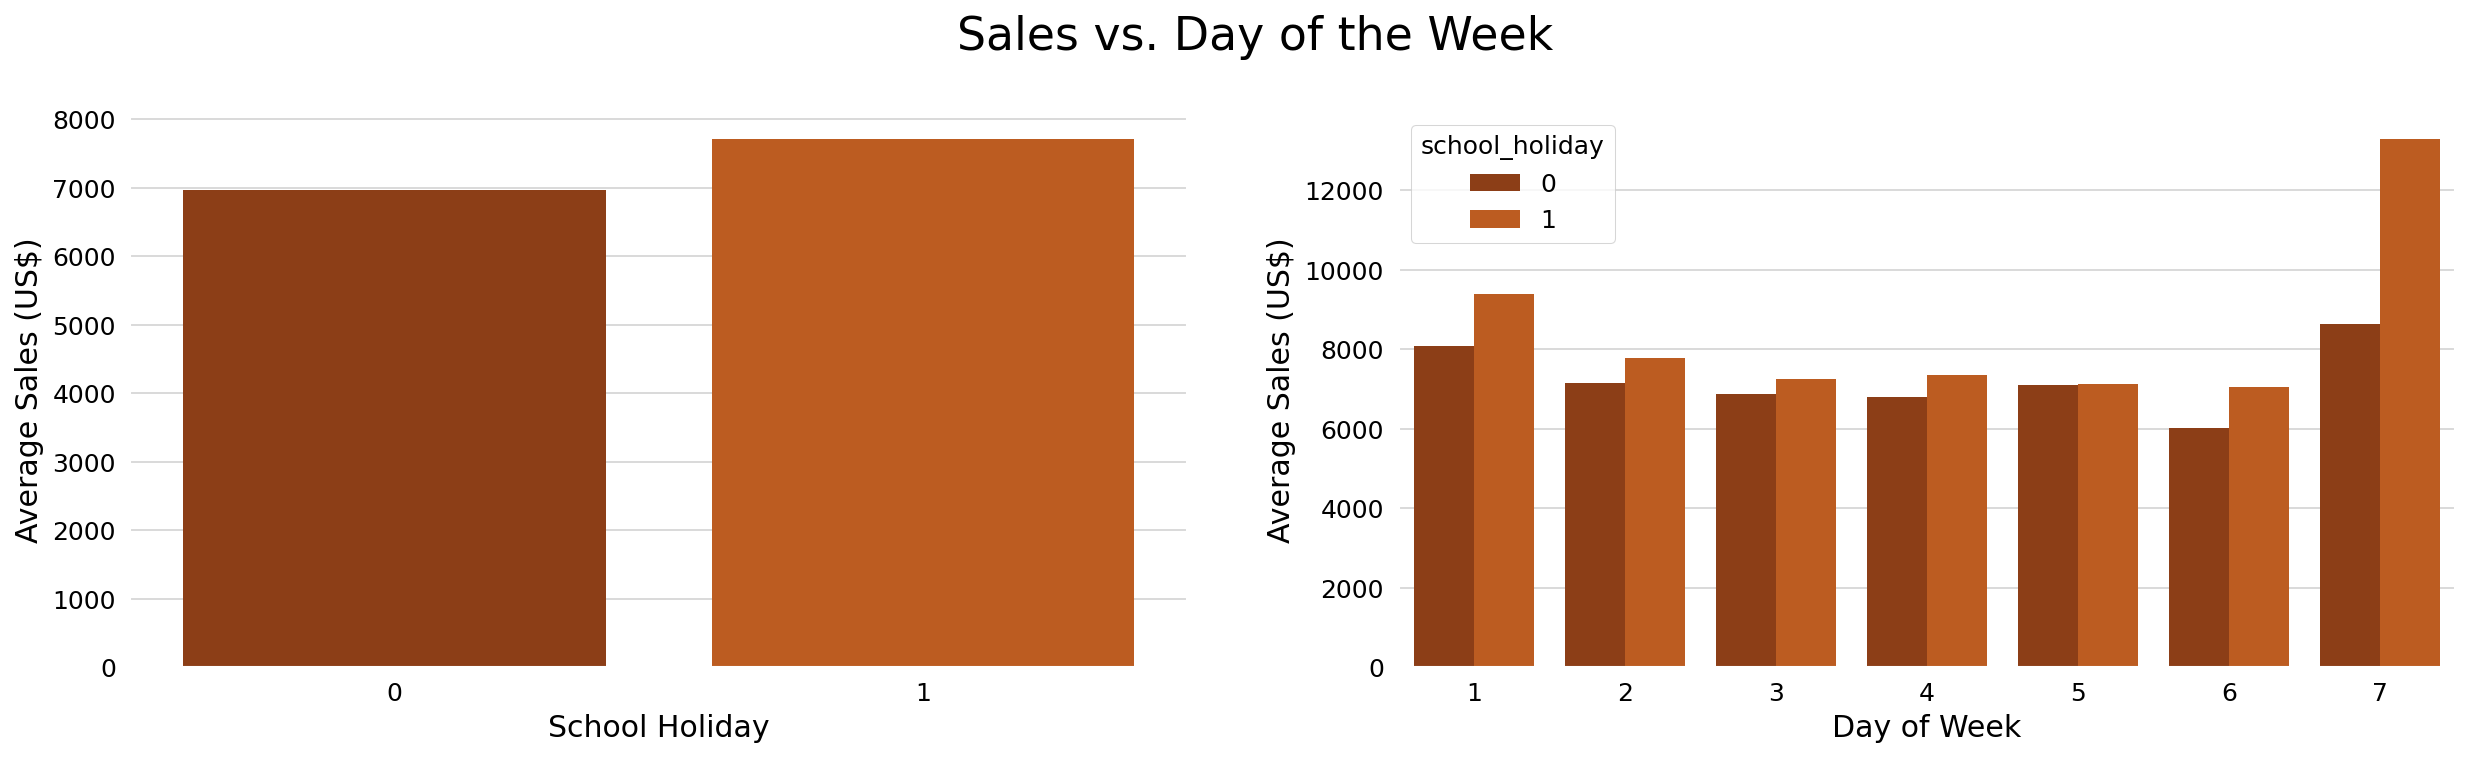

In [187]:
# Creating figure
fig_h11, axes = plt.subplots(nrows=1, ncols=3)

# Setting title for main figure
fig_h11.suptitle('Sales vs. Day of the Week', fontsize=22)

# Adjusting spacing
fig_h11.subplots_adjust(top=0.85)

# Manipulating data
aux1 = df1[['school_holiday', 'sales']].groupby(['school_holiday']).mean().reset_index()
aux2 = df1[['day_of_week', 'school_holiday', 'sales']].groupby(['day_of_week','school_holiday']).mean().reset_index()

# Plotting
plt.subplot(1, 2, 1)
sns.barplot(data=aux1, x='school_holiday', y='sales')
set_image(None, 'School Holiday', 'Average Sales (US$)')

plt.subplot(1, 2, 2)
sns.barplot(data=aux2, x='day_of_week', y='sales', hue='school_holiday')
set_image(None, 'Day of Week', 'Average Sales (US$)')

### 5.3. Final List of Hypotheses

**H1:** Stores with higher assortment level are supposed to sell more.

> **FALSE**: Stores with higher assortment level sell **less** than the other two.

**H2:** Stores with higher number of nearby competitors are supposed to sell less.

> **FALSE**: Stores with higher number of nearby competitors sell more!

**H3:** Stores with competitors for a longer period of time sell more.

> **FALSE**: Stores with competitors for longer period of time sell less.

**H4:** Stores that keep promotions for longer periods are supposed to sell more. 

> **TRUE**: Stores that keep promotions for longer periods sell more after a certain period of time.

**H5:** Stores that participate in more consecutive promotions are supposed to sell more.

> **FALSE**: Stores that participate in more consecutive promotions sell less.

**H6:** Regular days sell less than holidays on average.

> **TRUE**: Stores open on holidays sell more than regular days on average.

**H7** Stores are supposed to sell more before the 15th day of each month.

> **FALSE**: Stores sell slightly less before the 15th day of each month.

**H8:** Stores are supposed to sell less during the weekend on average.

> **FALSE**: Stores sell more on Sunday than any other day, but Saturday is the least popular day of the week for shopping.

**H9:** Stores are supposed to sell less during school holidays.

> **FALSE**: Stores sell more during school holidays.

### 5.4. Numerical Attributes

In [188]:
# Selecting only numerical variables
num_attributes = df1.select_dtypes(exclude=['object', 'datetime']).drop(columns=['store'], axis=1)

In [189]:
# Displaying mean, std, min, percentiles [25%, 50% (median), 75%], max
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
day_of_week,196032.00,3.53,1.72,1.00,2.00,4.00,5.00,7.00
sales,196032.00,7088.13,3034.24,0.00,5042.00,6530.00,8486.00,41551.00
customers,196032.00,752.67,388.08,0.00,520.00,670.00,877.00,5458.00
promo,196032.00,0.47,0.50,0.00,0.00,0.00,1.00,1.00
school_holiday,196032.00,0.16,0.37,0.00,0.00,0.00,0.00,1.00
comp_distance,195506.00,5433.23,7752.82,20.00,720.00,2320.00,6890.00,75860.00
comp_open_month,196032.00,6.21,3.25,1.00,4.00,6.00,9.00,12.00
comp_open_year,196032.00,2010.76,4.93,1972.00,2008.00,2012.00,2015.00,2015.00
promo2,196032.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
promo2_since_week,196032.00,19.96,12.39,1.00,10.00,18.00,29.00,50.00


In [190]:
# Other statistics
ranges      = num_attributes.apply(lambda x: x.max() - x.min())
skewness    = num_attributes.apply(lambda x: x.skew())
kurtosis    = num_attributes.apply(lambda x: x.kurtosis())

# Creating a dataframe
aux         = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis, 'Range': ranges})
aux

,Skewness,Kurtosis,Range
day_of_week,0.01,-1.25,6.00
sales,1.53,4.56,41551.00
customers,2.92,14.45,5458.00
promo,0.13,-1.98,1.00
school_holiday,1.84,1.40,1.00
comp_distance,2.97,13.43,75840.00
comp_open_month,0.19,-1.12,11.00
comp_open_year,-1.81,7.13,43.00
promo2,-0.04,-2.00,1.00
promo2_since_week,0.41,-0.84,49.00


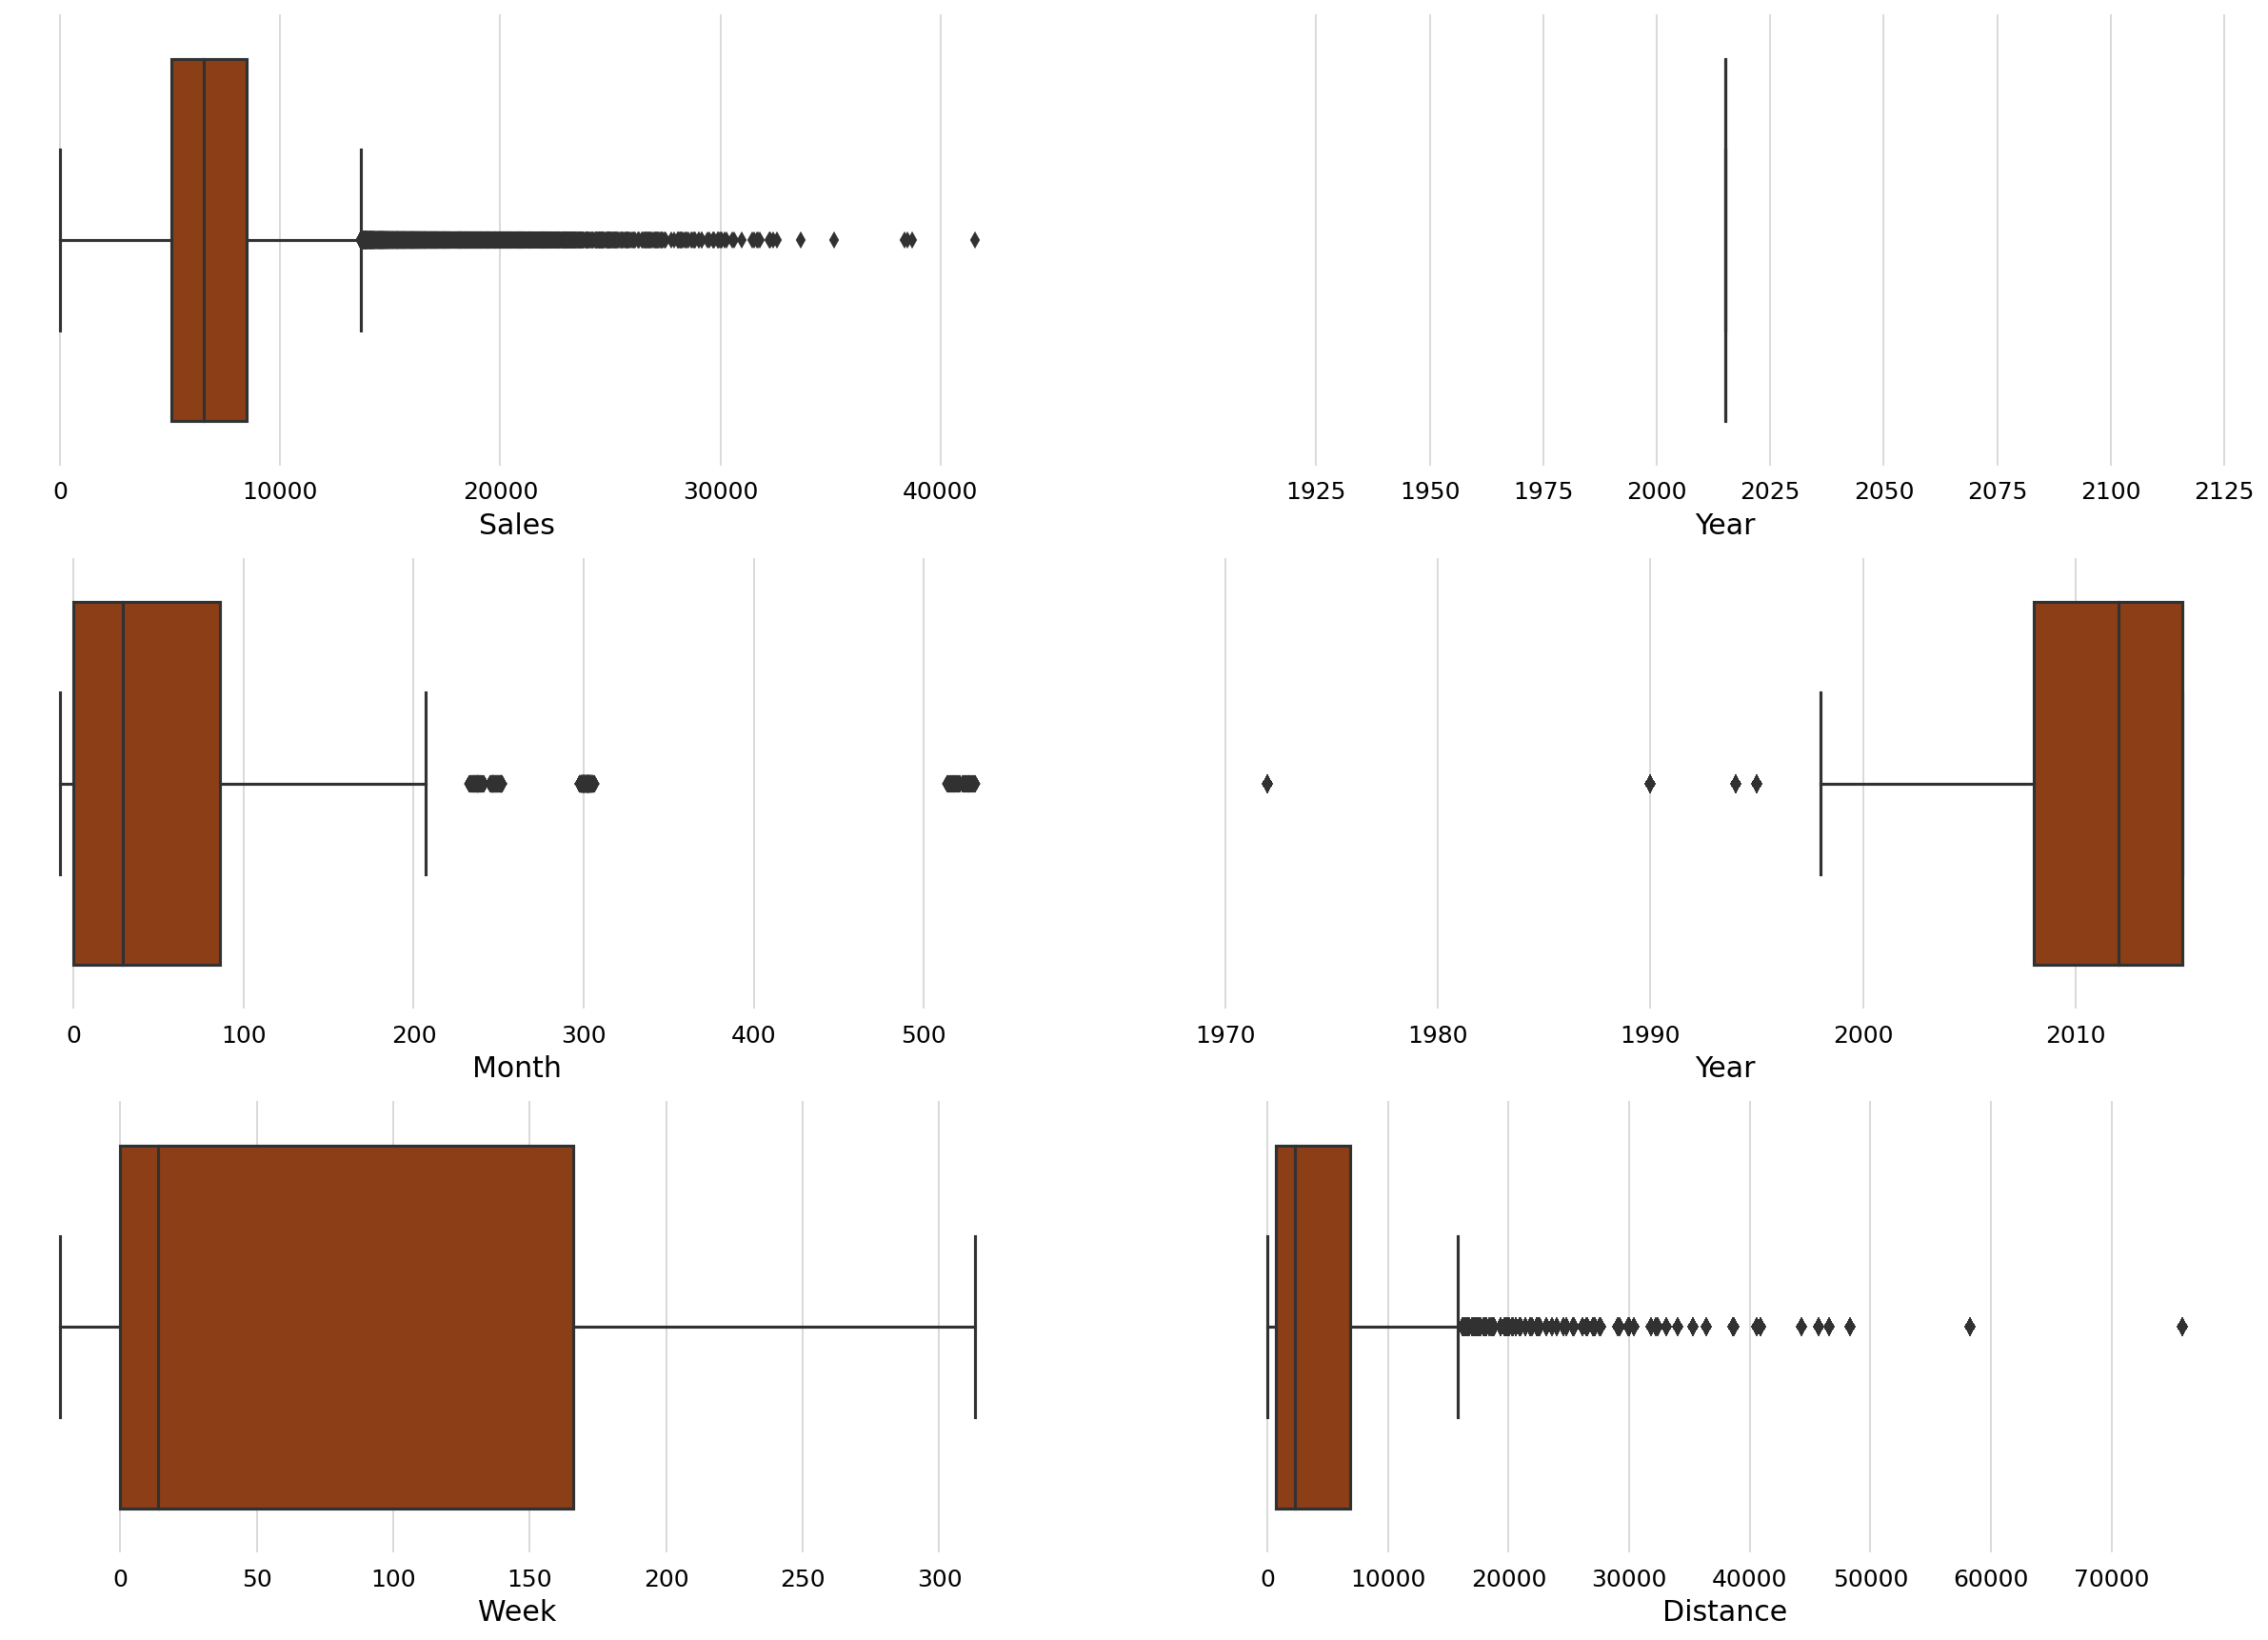

In [310]:
plt.figure(figsize=(20,14))

plt.subplot(3,2,1)
sns.boxplot(x= df1['sales'], orient='h')
set_image(None, 'Sales', None)

plt.subplot(3,2,2)
sns.boxplot(x = df1['year'], orient='h')
set_image(None, 'Year', None)

plt.subplot(3,2,3)
sns.boxplot(x = df1['comp_time_month'], orient='h')
set_image(None, 'Month', None)

plt.subplot(3,2,4)
sns.boxplot(x = df1['comp_open_year'], orient='h')
set_image(None, 'Year', None)

plt.subplot(3,2,5)
sns.boxplot(x = df1['promo_time_week'], orient='h')
set_image(None, 'Week', None)

plt.subplot(3,2,6)
sns.boxplot(x = df1['comp_distance'], orient='h')
set_image(None, 'Distance', None)

### 5.5. Categorical attributes

In [191]:
cat_attributes = df1.select_dtypes(include=['object']).drop(columns=['year_week'], axis=1)
cat_attributes

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic
...,...,...,...
235997,public_holiday,b,extra
236033,public_holiday,b,extra
236212,public_holiday,b,extra
236345,public_holiday,b,basic


### 5.6. Summary statistics

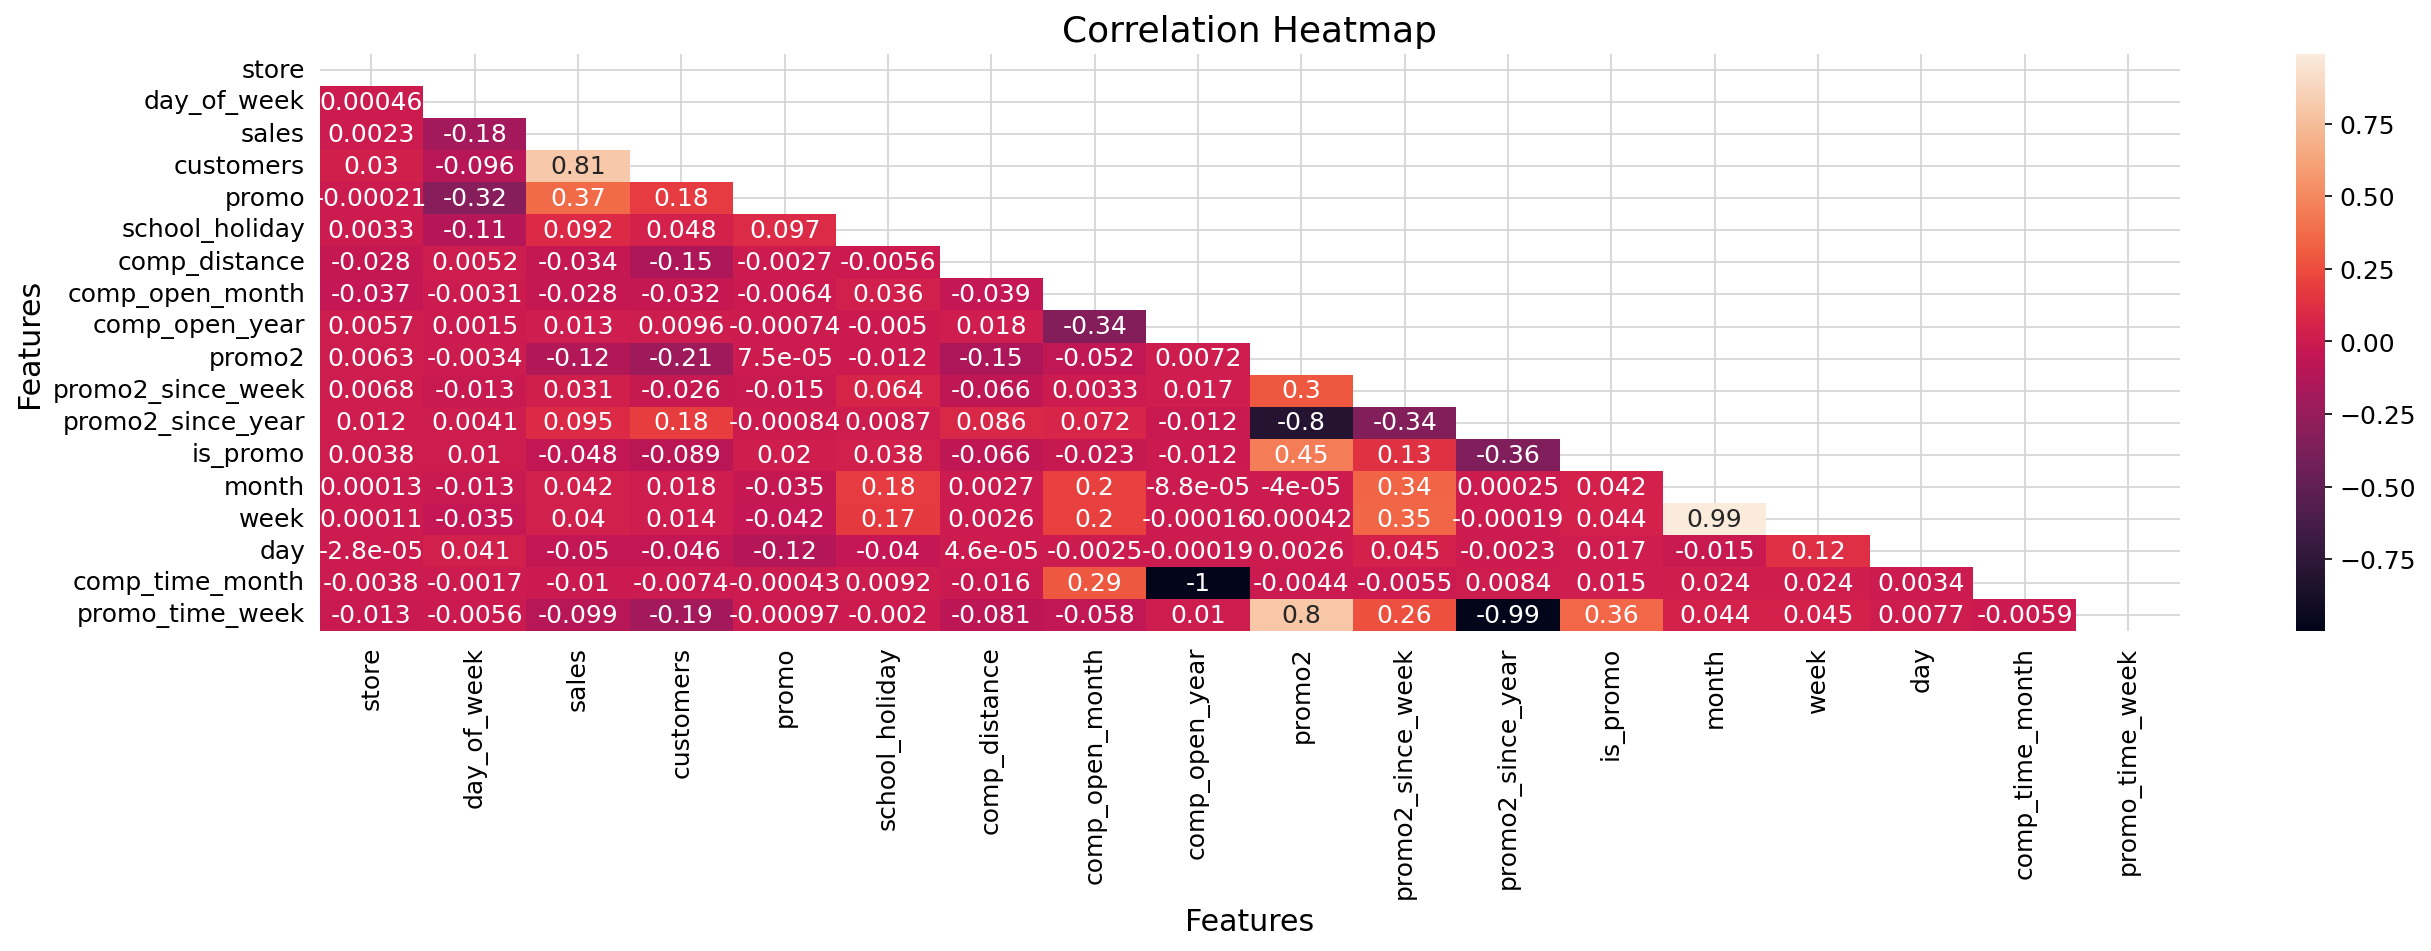

In [192]:
# Data manipulation
aux = df1.select_dtypes(exclude=['object', 'datetime']).drop(columns=['year'], axis=1)
# Correlation
correlation = aux.corr(method='pearson')
# Plot
sns.heatmap(correlation, annot=True, mask= np.triu(correlation))
# Settings
set_image('Correlation Heatmap', 'Features', 'Features', 90)

## 6. Data Preparation

### 6.1. Train-test split

#### 6.1.1. Split by date

In [194]:
df1['week'].unique()

array([31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
      dtype=int64)

In [195]:
df1.loc[df1['week'] == 31]['date'].unique()

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000'], dtype='datetime64[ns]')

In [196]:
# Considering that the last week has only 5 days of data, we will cut it at june 20th 
# to have 42 days (6 weeks) of data ahead and predict for the same amount that we want to forecast later

cutting_date = '2015-06-20'

# Training dataset
X_train     = df1[df1['date'] < cutting_date]
y_train     = X_train['sales']

# Test dataset
X_test      = df1[df1['date'] >= cutting_date]
y_test      = X_test['sales']

In [197]:
print('This way, the test size corresponds to {}% of the dataset.'.format(
    np.round(len(X_test['date'])/len(X_train['date'])*100, 2))) 

This way, the test size corresponds to 25.86% of the dataset.


### 6.2. Filling NaN 

In [198]:
# Let's suppose that the competition distance on NaN values is 15% greater than the maximum distance in the dataset
X_train['comp_distance'] = X_train['comp_distance'].apply(
    lambda x: X_train['comp_distance'].max()*1.15 if np.isnan(x) else x)

X_test['comp_distance'] = X_test['comp_distance'].apply(
    lambda x: X_test['comp_distance'].max()*1.15 if np.isnan(x) else x)

### 6.3. Rescaling

In [199]:
# The column 'promo_time_week' does not have a very large range of values, so only  Min-Max Scaler will be used
# Min-Max Scaler
mms = MinMaxScaler()

# Applying the Min-Max Scaler
X_train['promo_time_week'] = mms.fit_transform(X_train[['promo_time_week']].values)
X_test['promo_time_week'] = mms.transform(X_test[['promo_time_week']].values)

In [200]:
# Other columns have a bigger range of values, so Robust Scaler will be used
# Robust Scaler 
scaler = RobustScaler()

# Applying the Robust Scaler to the columns 
X_train[['comp_distance', 'comp_time_month', 'comp_open_year']] = scaler.fit_transform(
    X_train[['comp_distance', 'comp_time_month', 'comp_open_year']].values)

X_test[['comp_distance', 'comp_time_month', 'comp_open_year']] = scaler.transform(
    X_test[['comp_distance', 'comp_time_month', 'comp_open_year']].values)

### 6.4. Encoding

In [201]:
# Label Encoding for 'store_type' and 'state_holiday'
le = LabelEncoder()

# Applying the Label Encoding for 'store_type'
X_train['store_type'] = le.fit_transform(X_train['store_type'])
X_test['store_type'] = le.fit_transform(X_test['store_type'])

# Applying the Label Encoding for 'state_holiday'
X_train['state_holiday'] = le.fit_transform(X_train['state_holiday'])
X_test['state_holiday'] = le.fit_transform(X_test['state_holiday'])

In [202]:
# Ordinal Encoding for 'assortment'
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
# Mapping
X_train['assortment'] = X_train['assortment'].map(assortment_dict)
X_test['assortment'] = X_test['assortment'].map(assortment_dict)

### 6.5. Transformations

In [203]:
# Logarithmic transformations for 'sales' and 'customers'
X_train['sales'] = np.log1p(X_train['sales'])
X_train['customers'] = np.log1p(X_train['customers'])

X_test['sales'] = np.log1p(X_test['sales'])
X_test['customers'] = np.log1p(X_test['customers'])

In [222]:
# Nature transformations
# Day
X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# Day of week
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

### 6.6. Dropping Features

In [205]:
# Dropping unnecessary columns
X_train.drop(['year', 'customers', 'comp_since', 'promo_since', 'year_week'], axis=1, inplace=True)
X_test.drop(['year', 'customers', 'comp_since', 'promo_since', 'year_week'], axis=1, inplace=True)

### 6.7. Best Features from Boruta

In [206]:
# # Train and Test for Boruta
# X_train_boruta = X_train.drop(['sales', 'date'], axis=1)
# y_train_boruta = y_train

# # Random Forest
# rf = RandomForestRegressor()

# # Create the Boruta instance
# boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42)

# # Fit Boruta to data
# boruta = boruta_selector.fit(np.array(X_train_boruta), np.array(y_train_boruta))

### 6.8. Final Dataset

In [207]:
# # X_train feature selection (same as X_train_boruta, but as a DataFrame instead of array)
# X_train_fs = X_train.drop(['date'], axis=1) 

# # Gets all features boruta model considered as relevant
# cols_selected = boruta.support_.tolist() 

# # List of selected features
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() 

# # Not selected - Boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

# # Final features
# cols_selected_boruta_full = cols_selected_boruta.copy()

# # Adding 'date' and 'sales' in the end
# cols_selected_boruta_full.extend(feat_to_add) 

# # Saving
# x_train = X_train[cols_selected_boruta_full]
# x_test = X_test[cols_selected_boruta_full]

In [258]:
# Features used in ML mode
cols_selected_boruta = ['store',
                        'day_of_week', 
                        'promo',
                        'store_type',
                        'assortment',
                        'comp_distance',
                        'comp_open_month',
                        'comp_open_year',
                        'is_promo', 
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'comp_time_month',
                        'promo_time_week',
                        'day_sin',
                        'day_cos',
                        'day_of_week_sin',
                        'day_of_week_cos']

# Columns to add back
feat_to_add = ['date', 'sales']

# Final features
cols_selected_boruta_full = cols_selected_boruta.copy()

# Adding 'date' and 'sales' in the end
cols_selected_boruta_full.extend(feat_to_add) 

In [259]:
# Saving
x_train = X_train[cols_selected_boruta_full]
x_test = X_test[cols_selected_boruta_full]

# Final datasets
x_train = x_train.drop(['date', 'sales'], axis=1)
x_test = x_test.drop(['date', 'sales'], axis=1)

x_training = X_train[cols_selected_boruta_full]

## 7. Machine Learning Modeling

In this section, six models will be performed: 

- Average Model (baseline model)
- Linear Regression
- Lasso Regression 
- Random Forest Regressor
- XGBoost Regressor
- LightGBM Regressor

For each one of them the metrics Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE) and Coefficient of Determination (R2) will be calculated.

Beyond that, models will be trained under cross-validation as well.

### 7.1. Average Model (baseline model)

In [209]:
# Setting the Average Model as Baseline means that the other models have to perform better than it.
# Setting 'X_test' for the baseline
baseline = x_test.copy()

# Adding 'sales' column for prediction
baseline['sales'] = y_test.copy() 

# Calculating a prediction column where the predicted value is the mean for each store
predictions = baseline[['store', 'sales']].groupby(['store']).mean().reset_index().rename(columns={'sales': 'predictions'}) 

# Add 'predictions' to dataframe
baseline = pd.merge(baseline, predictions, how='left', on='store') 
y_predictions = baseline['predictions'] 

# Metrics
baseline_result = ml_error('Average Model (Baseline)', y_test, y_predictions)
baseline_result  

,Model,MAE,MAPE,RMSE,R2
0,Average Model (Baseline),1386.12,0.22,1836.36,0.64


In [266]:
# Setting the Average Model as Baseline means that the other models have to perform better than it.
# Setting 'X_test' for the baseline
baseline = x_test.copy()

# Adding 'sales' column for prediction
baseline['sales'] = y_test.copy() 

# Calculating a prediction column where the predicted value is the mean for each store
predictions = baseline[['store', 'sales']].groupby(['store']).mean().reset_index().rename(columns={'sales': 'predictions'}) 

# Add 'predictions' to dataframe
baseline = pd.merge(baseline, predictions, how='left', on='store') 
y_predictions = baseline['predictions'] 

# Metrics
baseline_result = ml_error('Average Model (Baseline)', y_test, y_predictions)
baseline_result  

,Model,MAE,MAPE,RMSE,R2
0,Average Model (Baseline),1386.12,0.22,1836.36,0.64


### 7.2. Linear Regression

In [265]:
# Fitting the Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', y_test, yhat_lr)
lr_result

,Model,MAE,MAPE,RMSE,R2
0,Linear Regression,2088.71,0.37,2742.11,0.19


#### 7.2.1. Linear Regression - Cross Validation

In [263]:
lr_result_cv = cross_validation(x_training, 2, 'Linear Regression CV', lr, verbose=False)
lr_result_cv

,Model CV,MAE CV,MAPE CV,RMSE CV,R2 CV
0,Linear Regression,0.28 +/- 0.0,496392570245.69 +/- 496392570245.6623,0.36 +/- 0.0,0.225 +/- 0.038


### 7.3. Lasso Regression

In [261]:
# Fitting the Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Lasso Regression', y_test, yhat_lrr)
lrr_result

,Model,MAE,MAPE,RMSE,R2
0,Lasso Regression,2086.74,0.37,2740.73,0.20


#### 7.3.1. Lasso Regression - Cross Validation

In [281]:
lrr_result_cv = cross_validation(x_training, 2, 'Lasso Regression CV', lrr)
lrr_result_cv

,Model CV,MAE CV,MAPE CV,RMSE CV,R2 CV
0,Lasso Regression CV,0.29 +/- 0.0,495231303373.93 +/- 495231303373.8929,0.37 +/- 0.01,0.1953 +/- 0.0115


### 7.4. Random Forest Regressor

In [270]:
rf = RandomForestRegressor(n_estimators=250, n_jobs=-1, random_state=42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', y_test, yhat_rf)
rf_result

,Model,MAE,MAPE,RMSE,R2
0,Random Forest Regressor,954.60,0.15,1372.42,0.80


#### 7.4.1. Random Forest Regressor - Cross Validation

In [271]:
rf_result_cv = cross_validation(x_training, 2, 'Random Forest Regressor CV', rf)
rf_result_cv

,Model CV,MAE CV,MAPE CV,RMSE CV,R2 CV
0,Random Forest Regressor CV,0.13 +/- 0.01,510605393040.8 +/- 510605393040.7863,0.18 +/- 0.02,0.7998 +/- 0.0318


### 7.5. XGBoost Regressor

In [273]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
            n_estimators=1000, 
            eta=0.01, 
            max_depth=10, 
            subsample=0.7,
            colsample_bytee=0.9).fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', y_test, yhat_xgb)
xgb_result

[13:37:12] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model,MAE,MAPE,RMSE,R2
0,XGBoost Regressor,1031.40,0.17,1422.48,0.78


#### 7.5.1. XGBoost Regressor - Cross Validation

In [274]:
xgb_result_cv = cross_validation(x_training, 2, 'XGBoost Regressor CV', model_xgb, verbose=False)
xgb_result_cv

[13:41:52] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[13:43:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.



,Model CV,MAE CV,MAPE CV,RMSE CV,R2 CV
0,XGBoost Regressor,0.15 +/- 0.02,507264443668.35 +/- 507264443668.3328,0.2 +/- 0.02,0.7657 +/- 0.0424


### 7.6. LightGBM Regressor

In [276]:
model_lgbm = lgb.LGBMRegressor(objective= 'regression',
                               n_estimators=3000, 
                               random_state=42).fit(x_train, y_train)

# Prediction
yhat_lgbm = model_lgbm.predict(x_test)

# Performance
lgbm_result = ml_error('LGBM Regressor', y_test, yhat_lgbm)
lgbm_result

,Model,MAE,MAPE,RMSE,R2
0,LGBM Regressor,890.65,0.14,1268.28,0.83


#### 7.6.1. LightGBM Regressor - Cross Validation

In [277]:
lgbm_result_cv = cross_validation(x_training, 2, 'LGBM Regressor CV', model_lgbm, verbose=False)
lgbm_result_cv

,Model CV,MAE CV,MAPE CV,RMSE CV,R2 CV
0,LGBM Regressor CV,0.12 +/- 0.02,506506431766.02 +/- 506506431766.0073,0.18 +/- 0.03,0.8223 +/- 0.0384


### 7.7. Comparing Models

The metrics did not perform as expected considering the models performances under Cross Validation. For example, MAPE values were very high. The resampling of the data did not improve the results, probably due to the lack of data available (only a few months of 2015) and the obligation of being in order of time.

Due to this, the models will be classified by their metrics without resampling.

In [279]:
models_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result])
models_results.sort_values('RMSE', ascending=True)

,Model,MAE,MAPE,RMSE,R2
0,LGBM Regressor,890.65,0.14,1268.28,0.83
0,Random Forest Regressor,954.60,0.15,1372.42,0.80
0,XGBoost Regressor,1031.40,0.17,1422.48,0.78
0,Average Model (Baseline),1386.12,0.22,1836.36,0.64
0,Lasso Regression,2086.74,0.37,2740.73,0.20
0,Linear Regression,2088.71,0.37,2742.11,0.19


## 8. Hyperparameter Tuning

### 8.1. Random Search

Random Search is used to find the best parameters for each model. Other options are Grid Search and Bayesian Optimization, but they are more computationally expensive and so they are not used.

In [294]:
# Using Random Search on LGBM model 

trials = 10
search_space = {
    'n_estimators': [3000, 3500, 4000, 4500], 
    'learning_rate': [0.03, 0.05, 0.07], 
    'max_depth': [7, 8],
    'num_leaves': [64, 128]
}

# Hyperparameters Search for LGBM
random_search_lgbm(search_space, x_train, y_train, trials) 

{'n_estimators': 3000, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 128}
{'n_estimators': 3500, 'learning_rate': 0.07, 'max_depth': 7, 'num_leaves': 64}
{'n_estimators': 4500, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 128}
{'n_estimators': 3500, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 128}
{'n_estimators': 3500, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 64}
{'n_estimators': 3500, 'learning_rate': 0.07, 'max_depth': 7, 'num_leaves': 64}
{'n_estimators': 4000, 'learning_rate': 0.03, 'max_depth': 7, 'num_leaves': 64}
{'n_estimators': 4000, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 128}
{'n_estimators': 3500, 'learning_rate': 0.05, 'max_depth': 8, 'num_leaves': 64}
{'n_estimators': 4500, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 64}


,Model,MAE,MAPE,RMSE,R2
0,LGBM Regressor,913.37,0.15,1299.71,0.82
0,LGBM Regressor,908.26,0.15,1292.97,0.82
0,LGBM Regressor,885.55,0.14,1272.60,0.83
0,LGBM Regressor,911.69,0.15,1297.32,0.82
0,LGBM Regressor,911.06,0.15,1294.77,0.82
0,LGBM Regressor,908.26,0.15,1292.97,0.82
0,LGBM Regressor,910.09,0.15,1288.16,0.82
0,LGBM Regressor,909.15,0.15,1295.70,0.82
0,LGBM Regressor,890.95,0.14,1274.23,0.83
0,LGBM Regressor,902.53,0.14,1285.94,0.82


### 8.2. Final Model

In [295]:
# Hyperparameters Tuned for LGBM

model = lgb.LGBMRegressor(  objective = 'regression', 
                            random_state = 42, 
                            subsample = 0.7,
                            colsample_bytree = 0.9,
                            min_child_samples = 100,  
                            n_estimators = 4500,
                            learning_rate = 0.05,
                            max_depth = 8,
                            num_leaves = 128).fit(x_train, y_train)

# Prediction
yhat_lgbm = model.predict(x_test)

# Performance
lgbm_result = ml_error('LGBM Regressor', y_test, yhat_lgbm)
lgbm_result

,Model,MAE,MAPE,RMSE,R2
0,LGBM Regressor,885.55,0.14,1272.60,0.83


## 9. Business Performance

In [296]:
# Creating final dataset
df_results = X_test[cols_selected_boruta_full]

# Adding LGBM predictions to the dataset
df_results['prediction'] = yhat_lgbm

### 9.1. Financial Performance

In [301]:
aux = df_results[['store', 'sales', 'prediction']].groupby(['store']).sum().reset_index()
aux

,store,sales,prediction
0,1,301.47,195146.05
1,2,304.54,174664.63
2,3,316.45,258819.89
3,4,331.03,360585.15
4,5,300.17,173552.74
...,...,...,...
1110,1111,301.88,180568.31
1111,1112,324.79,363176.91
1112,1113,315.80,231755.33
1113,1114,360.88,795515.13


In [303]:
# Sum of predictions
aux = df_results[['store', 'prediction']].groupby(['store']).sum().reset_index()

# MAE and MAPE
aux1 = df_results[['store', 'sales', 'prediction']].groupby('store').apply( 
    lambda x: mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns={0:'MAE'})

aux2 = df_results[['store', 'sales', 'prediction']].groupby('store').apply( 
    lambda x: mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns={0:'MAPE'})

# Merge
aux3 = pd.merge(aux1, aux2, how='inner', on='store')
df_performance = pd.merge(aux, aux3, how='inner', on='store')

# Scenarios
df_performance['worst_scenario']    = df_performance['prediction'] - df_performance['MAE']
df_performance['best_scenario']     = df_performance['prediction'] + df_performance['MAE']

# Order columns
df_performance = df_performance[['store', 'worst_scenario', 'prediction', 'best_scenario', 'MAE', 'MAPE']]

# Display
df_performance.sort_values('MAPE', ascending=True).head(10)

,store,worst_scenario,prediction,best_scenario,MAE,MAPE
197,198,97934.40,100724.52,103514.65,2790.12,347.10
306,307,99714.51,102555.47,105396.43,2840.96,358.98
840,841,99552.81,102389.18,105225.54,2836.36,360.78
542,543,108325.69,111412.69,114499.70,3087.01,389.48
969,970,113335.32,116565.40,119795.49,3230.08,405.67
930,931,141642.83,145088.93,148535.03,3446.10,406.64
655,656,115809.47,119110.00,122410.54,3300.54,406.90
557,558,116715.90,120042.32,123368.74,3326.42,409.81
209,210,116553.21,119875.10,123196.98,3321.88,413.17
218,219,118299.25,121671.01,125042.76,3371.76,419.43


### 9.2. Total Performance

In [305]:
# Scenarios and Values
total_performance = df_performance[['prediction', 'worst_scenario', 'best_scenario']].apply(
    lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'} )

# Format
total_performance['Values'] = total_performance['Values'].map('${:,.2f}'.format)

# Display
total_performance

,Scenario,Values
0,prediction,"$295,581,222.65"
1,worst_scenario,"$287,416,916.76"
2,best_scenario,"$303,745,528.54"


## 10. Conclusion and Recommendations

In conclusion, this Data Science project has successfully delivered a Sales Prediction Model in order to optimize resource allocation for Rossmann store renovations. 

Through a complete Exploratory Data Analysis, the company gained valuable insights into the factors influencing sales, providing a solid foundation for decision-making.

However, it's worth noting that the project's potential could be further maximized with a larger dataset. While it's focused on the year 2015 for computational efficiency, the complete dataset contains over 1 million rows, significantly more than the 236k rows of data used in this analysis. This could have had significant implications for the under-performance of cross-validation.

Throughout the project, various Machine Learning models were evaluated, but future efforts could explore alternative methodologies. For example, forecasting the number of customers and incorporating this data into the model could be a promising avenue for further research. 

As Rossmann continues to evolve,the insights gained here offer a robust foundation for informed decision-making and future data-driven projects.